## Advanced Machine Learning
### Practical 4 - Meta-Learning

In this practical, we will train a meta-model for the few-shot learning setting. We want this meta-model to quickly be able to produce fine-tuned models that perform well on novel few-shot tasks.


This is a complex and abstract idea, and it is harder to explain than previous practicals. To help with the intuition, recall the few-shot learning setting:

![meta_learning_algorithm.png](https://i.imgur.com/l6t3e7T.png)

On the left is our **meta-training** dataset we use to train our meta-model. It is a dataset of **tasks**, each of them some few-shot N-way classification task.

On the right is the **meta-test** dataset we use to evaluate it. It contains few-shot tasks not seen during meta-training. We will guarantee this by making sure those tasks involve classifying *classes* that were never seen in any meta-training task.

### Reptile algorithm

We'll use Reptile as our meta-learning algorithm because it's relatively straight-forward to implement. It goes something like this:

First, we initialise a general-purpose meta-model (essentially a feature extraction backbone).
At each meta-training step:
- We sample a task from the task distribution.
- We fine-tune the model on this task.
- We update the meta-model's parameters to be some distance between the previous meta-model and the new fine-tuned model.
- Repeat.  

Then, to assess the meta-generalisation ability of our model to new, unseen few-shot tasks, we can:
- Define some new tasks from an unseen part of the task distribution
- Try fine-tuning the trained meta-model on each of these "meta-test" tasks
- Report the final validation accuracy averaged across all meta-test tasks  

#### Concrete Example
(based on the diagram above)

- Initialise the 'meta-model' backbone, and save it.

Meta-training episode 1:  
  - Define the task: cat-vs-bird discrimination.
  - Create a labelled support set: images of 4 cats and 4 birds.
  - Clone the saved meta-model and attach a task-specific 2-way classifier head.
  - Fine-tune this task-specific model on cats vs birds.
  - Update the meta-model based on the task model's backbone, and save it.


Meta-training episode 2:
  - Define the task: flower-vs-bike discrimination.
  - Create the labelled support set of 4 flowers and 4 bikes.
  - Clone the saved meta-model and attach a new task head.
  - Fine-tune the new task model on flowers vs bikes.
  - Update the meta-model based on the task model's backbone, and save it.

Repeat for some number of episodes, and save the final meta-model.  


Meta-evaluation:
  - Define the task: dog-vs-otter discrimination (when neither class has occurred in the meta-training task distribution)
  - Clone the meta-model from its final saved weights, and attach a new dog-vs-otter task head.
  - Fine-tune the new task model on dogs vs otters.
  - Report final validation accuracy on the dog-vs-otter validation (query) set.
  - Repeat for each meta-test task.

To see whether meta-learning in this way is actually effective, we will compare it to a non-meta-learning baseline: simply pre-training a backbone on the entire meta-training set at once, without breaking it down into few-shot tasks.

The meta-test set will be the same, because we're looking to train a model that generalises well to **new few-shot tasks**.


#### How to run this practical

If you don't have a GPU on your machine, you can download this notebook and upload it to [Kaggle](https://www.kaggle.com/code) or [Colab](https://colab.research.google.com/) to use their GPU resources.
- You'll need to toggle on GPU acceleration in whichever one you use. On Kaggle you have to toggle on internet access as well.
- Kaggle seems to be much more reliable in practice, but use whatever works for you.

In [1]:
# set up the environment and install any missing packages:
!pip install torch torchvision numpy scipy matplotlib pandas pillow tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
from PIL import Image
from tqdm import tqdm
import os

/home/ndelafuente/miniconda3/envs/pytorch-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

For our dataset, we'll use CIFAR-100. It contains many classes, some of them semantically related and some not, giving us good variety to produce many small few-shot tasks.

We will reserve a subset of classes for meta-testing, and use the rest for meta-training.

Below, we download the dataset and display some examples from it.

In [2]:
### download cifar:

cifar100 = datasets.CIFAR100(root='data/', download=True)
cifar100.name, cifar100.num_classes = 'CIFAR-100', len(cifar100.classes)
print(f'{cifar100.name}: {len(cifar100)} samples')

Files already downloaded and verified
CIFAR-100: 50000 samples


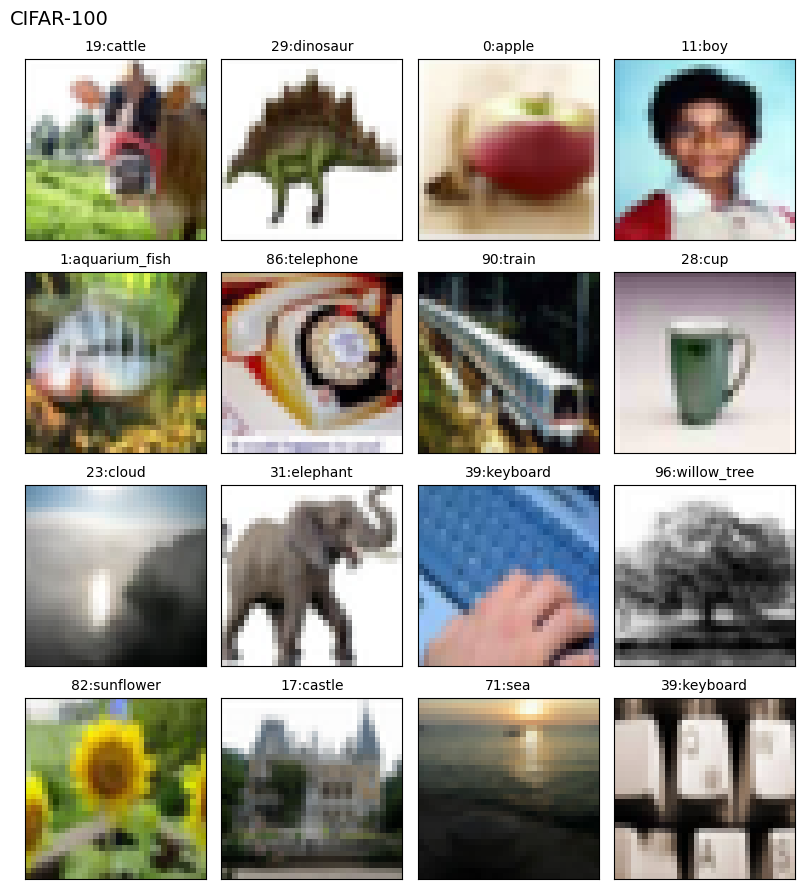

In [3]:
### helper function to inspect torch image batches:

def inspect_batch(images, # batch of images as torch tensors
        labels=None,      # optional vector of ground truth label integers
        predictions=None, # optional vector/matrix of model predictions
        # display parameters:
        class_names=None, # optional list or dict of class idxs to class name strings
        title=None,       # optional title for entire plot
        # figure display/sizing params:
        center_title=True,
        max_to_show=16,
        num_cols = 4,
        scale=1,
        ):
    """accepts a batch of images as a torch tensor or list of tensors,
    and plots them in a grid for manual inspection.
    optionally, you can supply ground truth labels
    and/or model predictions, to display those as well."""

    max_to_show = min([max_to_show, len(images)]) # cap at number of images

    num_rows = int(np.ceil(max_to_show / num_cols))

    # add extra figure height if needed for captions:
    extra_height = (((labels is not None) or (predictions is not None)) * 0.2)

    fig_width = 2 * scale * num_cols
    fig_height = (2+extra_height) * scale * num_rows + ((title is not None) * 0.3)

    fig, axes = plt.subplots(num_rows, num_cols, squeeze=False, figsize=(fig_width, fig_height))
    all_axes = []
    for ax_row in axes:
        all_axes.extend(ax_row)

    # translate labels and predictions to class names if given:
    if class_names is not None:
        if labels is not None:
            labels = [f'{l}:{class_names[int(l)]}' for l in labels]
        if predictions is not None:
            if len(predictions.shape) == 2:
                # probability distribution or onehot vector, so argmax it:
                predictions = predictions.argmax(dim=1)
            predictions = [f'{p}:{class_names[int(p)]}' for p in predictions]

    for b, ax in enumerate(all_axes):
        if b < max_to_show:
            # rearrange to H*W*C:
            img_p = images[b].permute([1,2,0])
            # un-normalise:
            img = (img_p - img_p.min()) / (img_p.max() - img_p.min())
            # to numpy:
            img = img.cpu().detach().numpy()

            ax.imshow(img)
            ax.axes.get_xaxis().set_ticks([])
            ax.axes.get_yaxis().set_ticks([])

            if labels is not None:
                ax.set_title(f'{labels[b]}', fontsize=10*scale**0.5)
            if predictions is not None:
                ax.set_title(f'pred: {predictions[b]}', fontsize=10*scale**0.5)
            if labels is not None and predictions is not None:
                if labels[b] == predictions[b]:
                    ### matching prediction, mark as correct:
                    mark, color = '✔', 'green'
                else:
                    mark, color = '✘', 'red'

                ax.set_title(f'label:{labels[b]}    \npred:{predictions[b]} {mark}', color=color, fontsize=8*scale**0.5)
        else:
            ax.axis('off')
    if title is not None:
        if center_title:
            x, align = 0.5, 'center'
        else:
            x, align = 0, 'left'
        fig.suptitle(title, fontsize=14*scale**0.5, x=x, horizontalalignment=align)
    fig.tight_layout()
    plt.show()

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar_batch = [cifar100[i] for i in range(16)]
cifar_images = [preprocess(img) for (img,label) in cifar_batch]
cifar_labels = [label for (img,label) in cifar_batch]

inspect_batch(cifar_images, cifar_labels, class_names=cifar100.classes, title='CIFAR-100', center_title=False)
# inspect_data(cifar100)

In [4]:
### here we break up the dataset into meta-training and meta-test classes,
### based on the superclass cluster groupings in the cifar-100 labels.

superclasses = {
   "aquatic mammals": ["beaver", "dolphin", "otter", "seal", "whale"],
              "fish": ["aquarium_fish", "flatfish", "ray", "shark", "trout"],
           "flowers": ["orchid", "poppy", "rose", "sunflower", "tulip"],
   "food containers": ["bottle", "bowl", "can", "cup", "plate"],
     "fruit and veg": ["apple", "mushroom", "orange", "pear", "sweet_pepper"],
       "electricals": ["clock", "keyboard", "lamp", "telephone", "television"],
         "furniture": ["bed", "chair", "couch", "table", "wardrobe"],
           "insects": ["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
  "large carnivores": ["bear", "leopard", "lion", "tiger", "wolf"],
   "large buildings": ["bridge", "castle", "house", "road", "skyscraper"],
    "natural scenes": ["cloud", "forest", "mountain", "plain", "sea"],
  "large herbivores": ["camel", "cattle", "chimpanzee", "elephant", "kangaroo"],
    "medium mammals": ["fox", "porcupine", "possum", "raccoon", "skunk"],
     "invertebrates": ["crab", "lobster", "snail", "spider", "worm"],
            "people": ["baby", "boy", "girl", "man", "woman"],
          "reptiles": ["crocodile", "dinosaur", "lizard", "snake", "turtle"],
     "small mammals": ["hamster", "mouse", "rabbit", "shrew", "squirrel"],
             "trees": ["maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"],
          "vehicles": ["bicycle", "bus", "motorcycle", "pickup_truck", "train"],
    "weird vehicles": ["lawn_mower", "rocket", "streetcar", "tank", "tractor"]
}

# pre-determine some classes we will only use in our meta-test set:
meta_test_superclasses = 'electricals', 'reptiles', 'fruit and veg', 'large buildings'

# and use all the others for meta-training
meta_train_superclasses = [cl for cl in superclasses.keys() if cl not in meta_test_superclasses]

all_classes, meta_train_classes, meta_test_classes = [], [], []
for superclass, classes in superclasses.items():
    all_classes.extend(classes)
    if superclass in meta_test_superclasses:
        meta_test_classes.extend(classes)
    if superclass in meta_train_superclasses:
        meta_train_classes.extend(classes)

print(f'{len(meta_test_classes)} meta-test classes: {meta_test_classes}\n')

print(f'{len(meta_train_classes)} meta-train classes: {meta_train_classes}\n')




20 meta-test classes: ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper', 'clock', 'keyboard', 'lamp', 'telephone', 'television', 'bridge', 'castle', 'house', 'road', 'skyscraper', 'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle']

80 meta-train classes: ['beaver', 'dolphin', 'otter', 'seal', 'whale', 'aquarium_fish', 'flatfish', 'ray', 'shark', 'trout', 'orchid', 'poppy', 'rose', 'sunflower', 'tulip', 'bottle', 'bowl', 'can', 'cup', 'plate', 'bed', 'chair', 'couch', 'table', 'wardrobe', 'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach', 'bear', 'leopard', 'lion', 'tiger', 'wolf', 'cloud', 'forest', 'mountain', 'plain', 'sea', 'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo', 'fox', 'porcupine', 'possum', 'raccoon', 'skunk', 'crab', 'lobster', 'snail', 'spider', 'worm', 'baby', 'boy', 'girl', 'man', 'woman', 'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel', 'maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree', 'bicycle', 'bus', 'motorcycle', 'pickup_

#### Meta-test set

To create our meta-test set, we will randomly sample from the available meta-test classes and create a different few-shot classification task from each of those subsets.

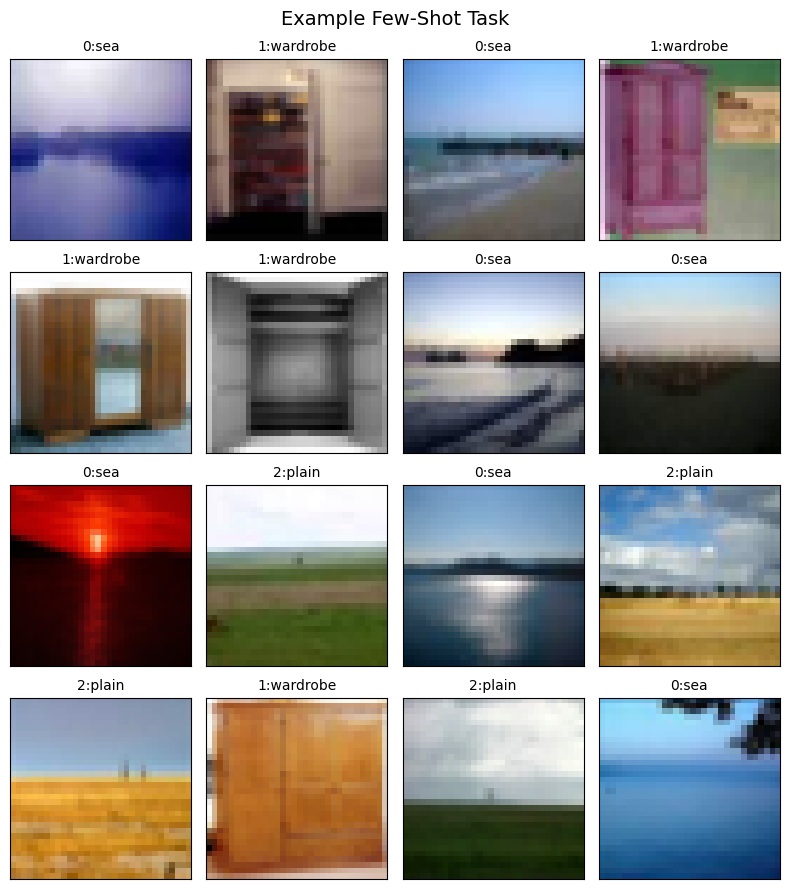

In [5]:
def create_task(num_support, # number of examples per class for support set
                num_query,   # number of examples per class for query set
                N_choices = [3,4,5], # choice of N-way classification
                meta_test=False, # generate from meta-test classes instead of meta-train classes
                within_superclass=False, # generate from within a superclass (for harder tasks)
               ):
    """creates a classification task from the possible cifar-100 classes.
    returns the support and query datasets for that task as a tuple"""

    # choose the number of classes to classify:
    num_task_classes = np.random.choice(N_choices)

    if meta_test:
        # draw from meta-test:
        meta_classes, meta_superclasses = meta_test_classes, meta_test_superclasses
    else:
        # draw from meta-train:
        meta_classes, meta_superclasses = meta_train_classes, meta_train_superclasses

    if not within_superclass:
        # choose that many classes from the available meta-train classes:
        task_classes = np.random.choice(meta_classes, size=num_task_classes, replace=False)
    elif within_superclass:
        # choose a superclass and sample the classes within that only:
        task_superclass = np.random.choice(meta_superclasses)
        task_classes = np.random.choice(superclasses[task_superclass], size=num_task_classes, replace=False)

    # image-label pairs for support (training) mini-dataset:
    support_imgs, support_labels = [], []
    # image-label pairs for query (test) mini-dataset:
    query_imgs, query_labels = [], []

    # create the image-label pairs for each class:
    for c, class_name in enumerate(task_classes):
        # c is the 'new' integer label in the few-shot task
        class_num = cifar100.class_to_idx[class_name] # and this is the 'old' integer label in cifar100

        # randomly select a subset of the cifar100 examples of these classes:
        all_class_data_idxs = [idx for idx,label in enumerate(cifar100.targets) if label == class_num]
        np.random.shuffle(all_class_data_idxs)

        support_idxs = all_class_data_idxs[:num_support]
        query_idxs = all_class_data_idxs[-num_query:]

        # select images and create correct labels for them:
        support_imgs.extend([cifar100[idx][0] for idx in support_idxs])
        support_labels.extend([c] * num_support)

        query_imgs.extend([cifar100[idx][0] for idx in query_idxs])
        query_labels.extend([c] * num_query)

    # create x and y tensors:
    support_x = torch.stack([preprocess(img) for img in support_imgs])
    support_y = torch.Tensor(support_labels).long()
    support_data = torch.utils.data.TensorDataset(support_x, support_y)

    query_x = torch.stack([preprocess(img) for img in query_imgs])
    query_y = torch.Tensor(query_labels).long()
    query_data = torch.utils.data.TensorDataset(query_x, query_y)

    support_data.classes = query_data.classes = task_classes

    return support_data, query_data


# sanity check:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32

support_data, query_data = create_task(8, 8, meta_test=False, within_superclass=False)

support_loader, query_loader = [torch.utils.data.DataLoader(dset,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True)
                                for dset in (support_data, query_data)]

batch = next(iter(support_loader))
bx, by = batch

inspect_batch(bx, labels=by, class_names = support_data.classes, title='Example Few-Shot Task')


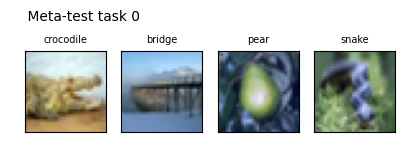

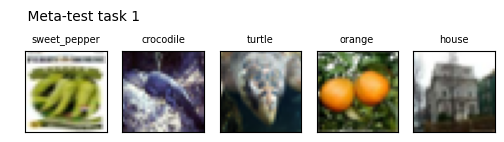

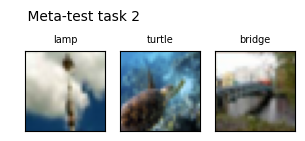

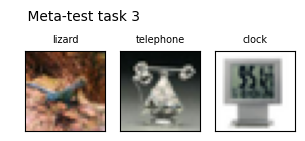

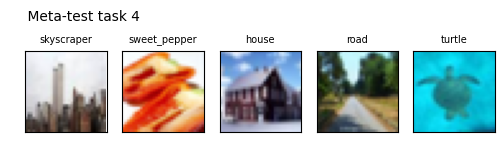

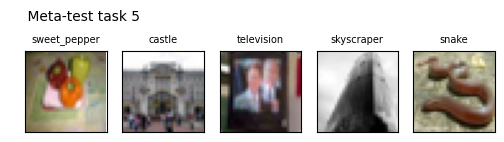

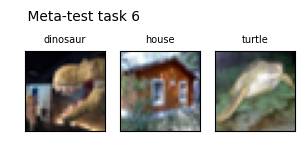

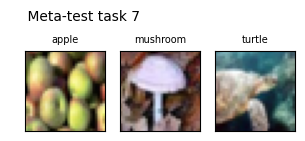

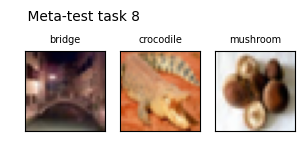

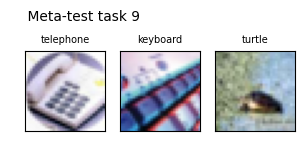

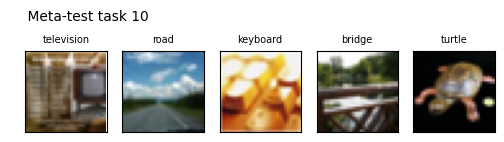

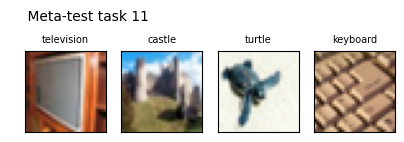

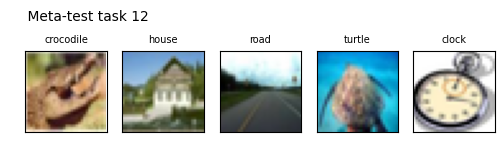

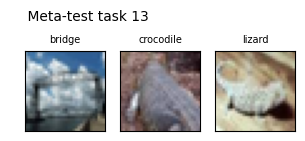

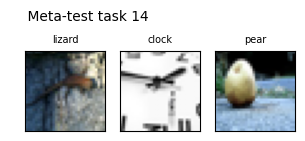

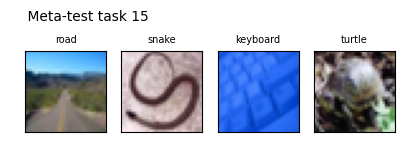

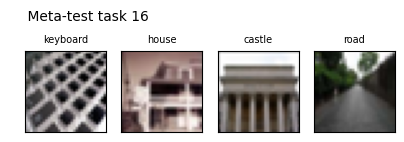

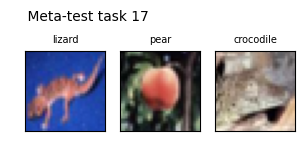

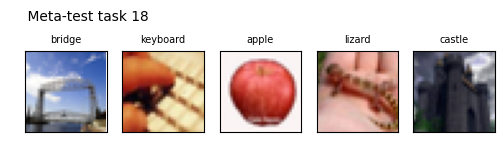

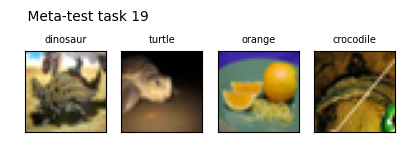

In [6]:
### META-TEST:

# for our meta test set, we generate 20 different few-shot tasks
# from the classes in our 'meta test classes' set.
# note that none of these are available during training!

NUM_TEST_TASKS = 20

np.random.seed(1)
meta_test_tasks = [create_task(num_support=4,    # 4 examples per class!!
                               num_query=8,
                               meta_test=True)
                   for t in range(NUM_TEST_TASKS)]

# quick function for displaying the classes of a few-shot task:
def inspect_task(task, title=None):
    num_task_classes = len(task[0].classes)
    task_classes = tuple([str(c) for c in task[0].classes])

    class_image_examples = [[img for (img,label) in task[0] if label==c][0] for c in range(num_task_classes)]
    inspect_batch(class_image_examples, labels=task_classes, scale=0.5, num_cols=num_task_classes, title=title, center_title=False)

meta_test_task_classes = []
for t, task in enumerate(meta_test_tasks):
    inspect_task(task, title=f'    Meta-test task {t}')
    meta_test_task_classes.append(tuple([str(c) for c in task[0].classes]))

### ideally, we want a model that gets good average validation accuracy on the set of these test tasks

## Models

Here we define a class for the models we will use in both training and meta-training.

Recall that meta-training is finding a good pre-trained initialisation, that we then fine-tune from.

So, as in transfer learning, our pre-training model is the feature extractor backbone, and the fine-tuning model

In practice, this means the 'meta-model' is an initialisation for the feature extractor, and the 'task models' are each trained from the meta-model's initialisation with a task-specific classifier head.

We'll use a `resnet34` for our backbone, and our classifier head will just be a linear projection over the ReLU activations of the feature extractor.

In [7]:
def initialise_backbone():
    return models.resnet34().to(device)

example_backbone = initialise_backbone()

# inspect the architecture if we want:
example_backbone

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
### define the classification head that we attach to the encoder backbone:
class ClassifierHead(nn.Module):
    def __init__(self, input_size, projection_size, num_classes, dropout=0):
        super().__init__()

        self.projection = nn.Linear(input_size, projection_size)
        self.classifier = nn.Linear(projection_size, num_classes)

        if dropout > 0:
            self.dropout = nn.Dropout(dropout)
        else:
            self.dropout = nn.Identity()

        self.relu = nn.ReLU()

    def forward(self, x):
        # assume x is already unactivated feature logits,
        # e.g. from resnet backbone
        x = self.projection(self.relu(self.dropout(x)))
        x = self.classifier(self.relu(self.dropout(x)))

        return x

## Baseline Training

As a baseline, we'll perform 'basic' transfer learning (without meta-learning) by pre-training on all the data from the entire meta-training set, then fine-tuning on the few-shot tasks in the meta-test set.

Below we define the baseline data loaders, as well as the usual helper functions for metric plotting and model training.

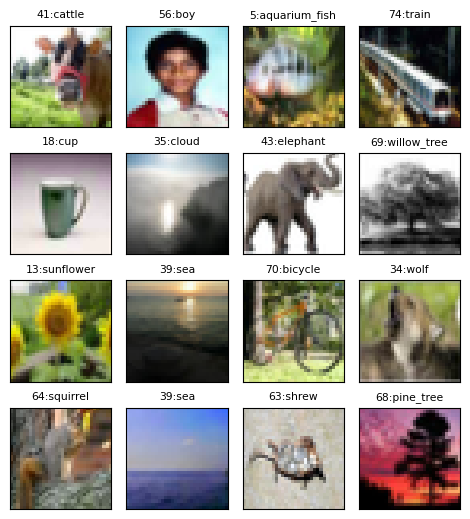

In [9]:
### generate baseline meta-training / meta-test sets:

### BASELINE TRAINING:

baseline_metatrain_class_idxs = [cifar100.class_to_idx[cl_name] for cl_name in meta_train_classes]
baseline_metatrain_class_data_idxs = [i for i, label in enumerate(cifar100.targets) if label in baseline_metatrain_class_idxs]
baseline_metatrain_examples = [cifar100[idx] for idx in baseline_metatrain_class_data_idxs]

baseline_metatrain_cl2idx = {cl_name: c for c, cl_name in enumerate(meta_train_classes)}
baseline_x_metatrain = torch.stack([preprocess(img) for img, label in baseline_metatrain_examples])
baseline_y_metatrain = torch.Tensor([baseline_metatrain_cl2idx[cifar100.classes[label]] for img, label in baseline_metatrain_examples]).long()

baseline_metatrain_data = torch.utils.data.TensorDataset(baseline_x_metatrain, baseline_y_metatrain)

# sanity check:
bbatch = baseline_metatrain_data[:16]
bimgs, blabels = bbatch
inspect_batch(bimgs, labels=blabels, class_names = meta_train_classes, scale=0.6)

In [10]:
### plotting and accuracy functions:

def training_plot(metrics,
      title=None, # optional figure title
      alpha=0.05, # smoothing parameter for train loss
      baselines=None, # optional list, or named dict, of baseline accuracies to compare to
      show_epochs=False, # display boundary lines between epochs
      ):

    train_losses, val_losses, train_accs, val_accs, epoch_steps = metrics

    fig, (loss_ax, acc_ax) = plt.subplots(1,2)



    ### plot loss:
    smooth_train_loss = pd.Series(train_losses).ewm(alpha=alpha).mean()
    steps = np.arange(0, len(train_losses))

    # train loss is plotted at every step:
    loss_ax.plot(steps, smooth_train_loss, 'b-', label='train loss')
    # but val loss is plotted at every epoch:
    loss_ax.plot(epoch_steps, val_losses, 'r-', label='val loss')

    loss_ax.legend(); loss_ax.set_xlabel('Training step'); loss_ax.set_ylabel('Loss (CXE)')


    ### plot acc:
    smooth_train_acc = pd.Series(train_accs).ewm(alpha=alpha).mean()

    acc_ax.plot(steps, smooth_train_acc, 'b-', label='train acc')
    acc_ax.plot(epoch_steps, val_accs, 'r-', label='val acc')

    acc_ax.legend(); acc_ax.set_xlabel('Training step'); acc_ax.set_ylabel('Accuracy')

    # format as percentage on right:
    acc_ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1.0))
    acc_ax.yaxis.tick_right()
    acc_ax.yaxis.set_label_position('right')

    # optionally, draw lines at baseline accuracy points:
    if baselines is not None:
        if type(baselines) is list:
            for height in baselines:
                acc_ax.axhline(height, c=[0.8]*3, linestyle=':')
            # rescale y-axis to accommodate baselines if needed:
            plt.ylim([0, max(list(smooth_train_acc) + val_accs + baselines)+0.05])
        elif type(baselines) is dict:
            for name, height in baselines.items():
                acc_ax.axhline(height, c=[0.8]*3, linestyle=':')
                # add text label as well:
                acc_ax.text(0, height+0.002, name, c=[0.6]*3, size=8)
            plt.ylim([0, max(list(smooth_train_acc) + val_accs + [h for h in baselines.values()])+0.05])

    # optionally, draw epoch boundaries
    if show_epochs:
        for ax in (loss_ax, acc_ax):
            for epoch in epoch_steps:
                ax.axvline(epoch, c=[0.9]*3, linestyle='--', zorder=0)


    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def get_batch_acc(pred, y):
    """calculates accuracy over a batch as a float
    given predicted logits 'pred' and integer targets 'y'"""
    return (pred.argmax(axis=1) == y).float().mean().item()

def get_topk_acc(pred, y, k=5):
    topk_labels = pred.topk(k,1,largest=True,sorted=True)[1]
    correct = [y[i] in topk_labels[i] for i in range(len(y))]
    avg_correct = float(np.mean(correct))
    return avg_correct

In [11]:
### supervised model training loop:

def train_supervised(model,
        train_loader,
        val_loader,
        ### hyperparameters:
        num_epochs,
        lr     = 1e-3,  # initial learning rate
        l2_reg = 0,     # L2 weight decay term (0 means no regularisation)
        gamma  = 1,     # exponential LR decay term (1 means no scheduling)
        early_stopping = False, # if True, automatically detect convergence and abort training
        ### metrics and plotting:
        use_top5_acc  = False,   # if True, use top-5 accuracy instead of top-1 accuracy metric
        plot          = True,
        show_progress = True,
        verbose       = True,
        baselines     = None, # optionally, a list or dict of validation accs to compare to
        show_epochs   = False, # display boundary lines between epochs
       ):

    # define loss and optimiser:
    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg)

    # learning rate scheduler:
    scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=gamma)

    # track metrics for plotting training curves:
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    epoch_steps = [] # used for plotting val loss at the correct x-position
    metrics = [train_losses, val_losses, train_accs, val_accs, epoch_steps]
    best_val_acc = 0

    steps_trained = 0
    consecutive_plateau_epochs = 0 # for checking convergence

    # for classification problems with very many classes,
    # it's common to use top5 instead of top1 accuracy as a fairer metric:
    if use_top5_acc:
        # top5; prediction is accurate if the correct class is in the top 5 predictions
        acc_fn = lambda pred,y: get_topk_acc(pred,y,k=5)
        acc_str = 'top5acc'
    else:
        # top1; prediction must be the exact correct class
        acc_fn = get_batch_acc
        acc_str = 'acc'

    if show_progress:
        # set a progress bar to loop over
        epoch_iter = tqdm(range(num_epochs), ncols=100)
    else:
        epoch_iter = range(num_epochs)

    for e in epoch_iter:
        model.train()
        epoch_train_losses, epoch_train_accs = [], []

        for batch in train_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)

            opt.zero_grad()

            pred = model(x)
            batch_loss = loss_fn(pred, y)
            batch_acc = acc_fn(pred, y)

            batch_loss.backward()
            opt.step()

            # track loss and accuracy:
            epoch_train_losses.append(batch_loss.item())
            epoch_train_accs.append(batch_acc)
            steps_trained += 1

        epoch_steps.append(steps_trained)
        scheduler.step()

        # record training metrics, by batch and over the epoch:
        train_losses.extend(epoch_train_losses)
        train_accs.extend(epoch_train_accs)

        # evaluate after each epoch::
        avg_val_loss, avg_val_acc = evaluate_model(model, val_loader, loss_fn, acc_fn)
        val_losses.append(avg_val_loss)
        val_accs.append(avg_val_acc)

        # update best accuracy:
        if val_accs[-1] > best_val_acc:
            best_val_acc = val_accs[-1]

        if show_progress:
            report = (f'E{e} loss t:{np.mean(epoch_train_losses):.2f}|v:{avg_val_loss:.2f}' +
                                  f'| {acc_str} t:{np.mean(epoch_train_accs):>5.1%}|v:{avg_val_acc:>5.1%}')

            if gamma < 1: # show current LR as well:
                report = f'LR: {scheduler.get_last_lr()[0]:.1e} | ' + report

            epoch_iter.set_description(report)

        if early_stopping and e > 0:
            # look for convergence by checking whether validation metrics
            # have stalled. if so, abort the training early

            val_loss_improvement = val_losses[-2] / val_losses[-1]

            val_acc_improvement = val_accs[-1] / (val_accs[-2] + 1e-8)
            # 1e-8 is a small 'fudge' epsilon to avoid div-zero errors in small batches

            # track consecutive epochs where neither loss nor accuracy moved: (much)
            if (val_acc_improvement < 1.01) and (val_loss_improvement < 1.01):
                consecutive_plateau_epochs +=1 # start counting a plateau
            else:
                consecutive_plateau_epochs = 0 # reset count

            # if plateaued for 2 consecutive epochs, stop:
            if early_stopping and (consecutive_plateau_epochs >= 2):
                if show_progress:
                    epoch_iter.close()
                if verbose:
                    print(f'  Converged at epoch: {e:>2}.', end=' ')
                break

    if baselines is None:
        # if no comparison baseline is provided,
        # just show the top val accuracy achieved this run
        baselines = {'best': best_val_acc}

    # plot training curves:
    if plot:
        training_plot(metrics, baselines=baselines, show_epochs=show_epochs)

    if verbose:
        print(f'Best validation accuracy: {best_val_acc:.2%}')

    return best_val_acc, metrics


def evaluate_model(model, val_loader,
                   loss_fn = nn.CrossEntropyLoss(),
                   acc_fn = get_batch_acc):
    """runs model on entirety of validation loader,
    with specified loss and accuracy functions,
    and returns average loss/acc over all batches"""
    with torch.no_grad():
        model.eval()
        batch_val_losses, batch_val_accs = [], []

        for batch in val_loader:
            vx, vy = batch
            vx, vy = vx.to(device), vy.to(device)

            vpred = model(vx)
            val_loss = loss_fn(vpred, vy)
            val_acc = acc_fn(vpred, vy)

            batch_val_losses.append(val_loss.item())
            batch_val_accs.append(val_acc)
    return np.mean(batch_val_losses), np.mean(batch_val_accs)



Pre-training baseline supervised model on 80-way classification:


LR: 3.6e-04 | E19 loss t:1.00|v:3.25| top5acc t:95.2%|v:67.0%:  63%|▋| 19/30 [01:17<00:44,  4.07s/it

  Converged at epoch: 19. 

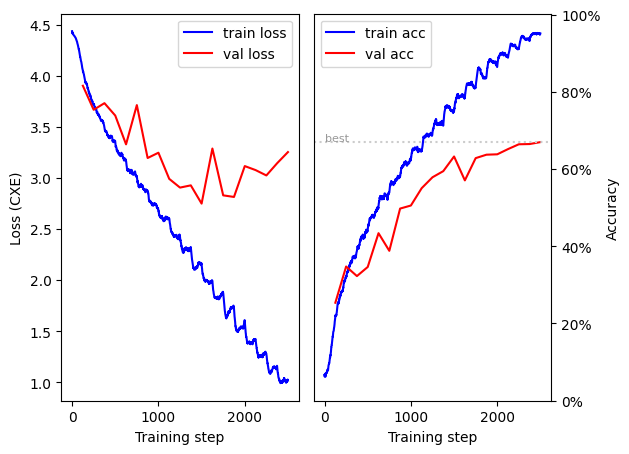

Best validation accuracy: 66.97%


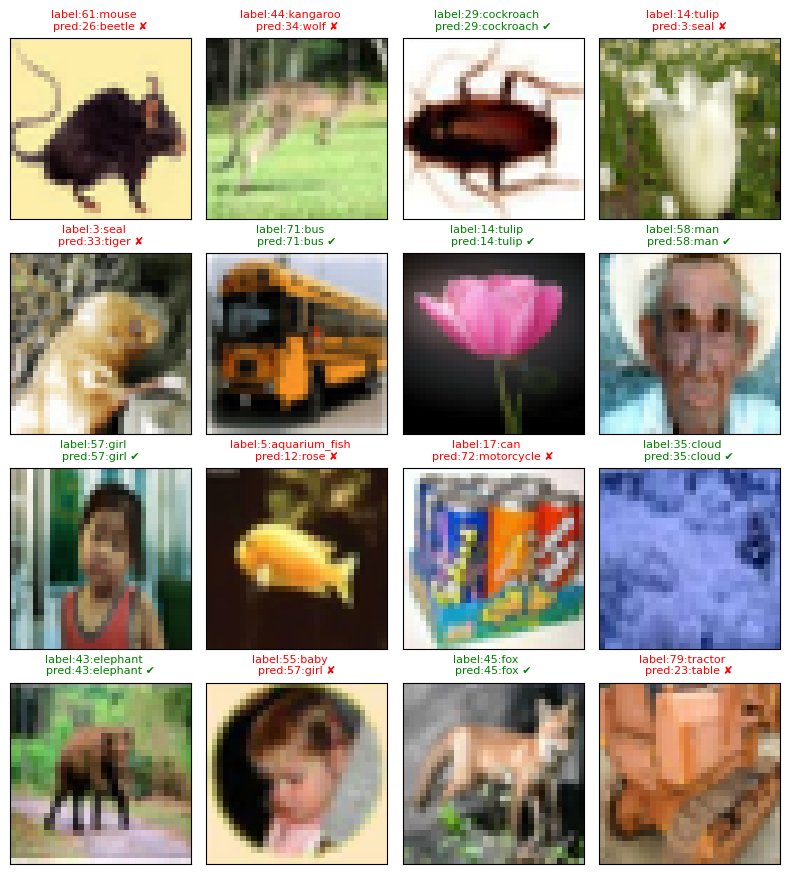

In [12]:
### set up baseline pretraining task:

# baseline train/validation split:
VAL_FRAC = 0.2
baseline_train, baseline_val = torch.utils.data.random_split(baseline_metatrain_data, [1-VAL_FRAC, VAL_FRAC])
baseline_train_loader, baseline_val_loader = [torch.utils.data.DataLoader(dset,
                                                 batch_size=256,
                                                 shuffle=True)
                                for dset in (baseline_train, baseline_val)]

print(f'\nPre-training baseline supervised model on {len(meta_train_classes)}-way classification:')

### training hyperparameters:
max_epochs = 30         # epochs to train for, unless stopped early
lr = 1e-3               # initial learning rate
l2_reg = 1e-3           # L2 loss term
gamma = 0.95            # exponential LR decay term
early_stopping = True   # detect convergence automatically

# initialise backbone and classification head:
baseline_backbone = initialise_backbone()
baseline_classifier = ClassifierHead(input_size=1000,
                                     projection_size=128,
                                     dropout=0.5,
                                     num_classes=len(meta_train_classes),
                                    ).to(device)

# wrap them into a supervised model:
baseline_model = nn.Sequential(baseline_backbone, baseline_classifier)

baseline_pretrain_acc, baseline_pretrain_metrics = train_supervised(baseline_model,
                                                           baseline_train_loader, baseline_val_loader,
                                                           max_epochs, lr, l2_reg, gamma,
                                                           early_stopping=True, use_top5_acc=True)

# inspect validation predictions:
val_x, val_y = next(iter(baseline_val_loader))
inspect_batch(val_x,
              labels=val_y,
              predictions=baseline_model(val_x.to(device)),
              class_names=meta_train_classes,
                )

### save the baseline checkpoint if we need it:

# keep things neat by storing model files in their own directory:
if not os.path.exists('ckpts'):
    os.mkdir('ckpts')

torch.save(baseline_backbone.state_dict(), 'ckpts/pretrained_backbone.pt')


Now we have a pre-trained model to use as our baseline (non-meta-learning) performance.

For meta-evaluation, we will repeatedly fine-tune it on each of our meta-test tasks. Since we're doing this a lot, it makes sense to define a function that takes a model backbone and quickly fine-tunes it on some specified task

/home/ndelafuente/miniconda3/envs/pytorch-env/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Baseline evaluation on meta-test set:

Fine-tuning on evaluation task 0:


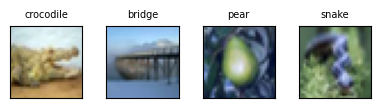

  Converged at epoch:  3. Best validation accuracy: 28.12%
Total backbone weight change during fine-tuning: 5.498210460180417

Fine-tuning on evaluation task 1:


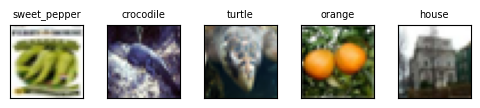

  Converged at epoch: 12. Best validation accuracy: 54.69%
Total backbone weight change during fine-tuning: 14.06796903628856

Fine-tuning on evaluation task 2:


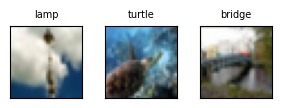

  Converged at epoch:  7. Best validation accuracy: 45.83%
Total backbone weight change during fine-tuning: 9.337808370124549

Fine-tuning on evaluation task 3:


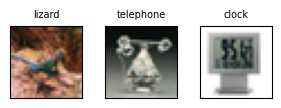

  Converged at epoch:  5. Best validation accuracy: 41.67%
Total backbone weight change during fine-tuning: 7.232508252374828

Fine-tuning on evaluation task 4:


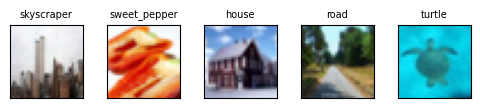

  Converged at epoch: 14. Best validation accuracy: 67.19%
Total backbone weight change during fine-tuning: 15.293268989771605

Fine-tuning on evaluation task 5:


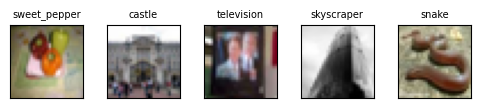

  Converged at epoch: 11. Best validation accuracy: 56.25%
Total backbone weight change during fine-tuning: 13.07100414391607

Fine-tuning on evaluation task 6:


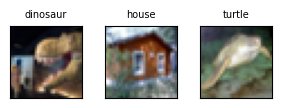

  Converged at epoch:  4. Best validation accuracy: 54.17%
Total backbone weight change during fine-tuning: 6.517769728088751

Fine-tuning on evaluation task 7:


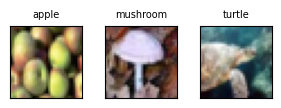

  Converged at epoch:  5. Best validation accuracy: 45.83%
Total backbone weight change during fine-tuning: 7.462760232388973

Fine-tuning on evaluation task 8:


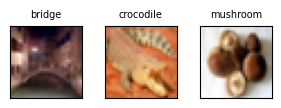

  Converged at epoch: 11. Best validation accuracy: 66.67%
Total backbone weight change during fine-tuning: 12.339570484589785

Fine-tuning on evaluation task 9:


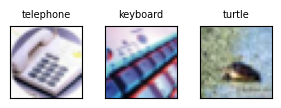

  Converged at epoch:  8. Best validation accuracy: 62.50%
Total backbone weight change during fine-tuning: 9.951639612903818

Fine-tuning on evaluation task 10:


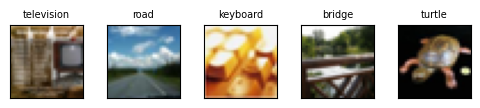

  Converged at epoch: 31. Best validation accuracy: 45.31%
Total backbone weight change during fine-tuning: 27.32243347680196

Fine-tuning on evaluation task 11:


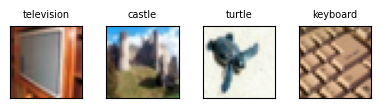

  Converged at epoch: 13. Best validation accuracy: 56.25%
Total backbone weight change during fine-tuning: 14.398327814415097

Fine-tuning on evaluation task 12:


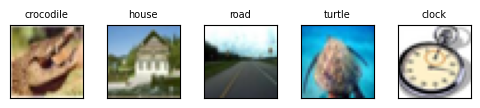

  Converged at epoch:  9. Best validation accuracy: 37.50%
Total backbone weight change during fine-tuning: 11.121745384065434

Fine-tuning on evaluation task 13:


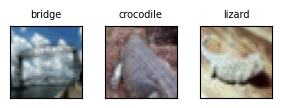

  Converged at epoch:  7. Best validation accuracy: 37.50%
Total backbone weight change during fine-tuning: 9.06065413588658

Fine-tuning on evaluation task 14:


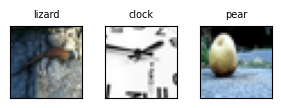

  Converged at epoch:  8. Best validation accuracy: 45.83%
Total backbone weight change during fine-tuning: 9.78543995693326

Fine-tuning on evaluation task 15:


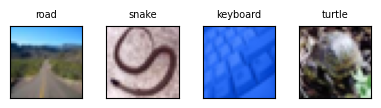

  Converged at epoch:  3. Best validation accuracy: 31.25%
Total backbone weight change during fine-tuning: 5.513885497814044

Fine-tuning on evaluation task 16:


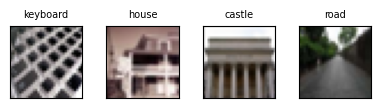

  Converged at epoch: 11. Best validation accuracy: 59.38%
Total backbone weight change during fine-tuning: 12.43728416482918

Fine-tuning on evaluation task 17:


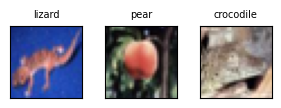

  Converged at epoch: 17. Best validation accuracy: 70.83%
Total backbone weight change during fine-tuning: 17.239093178883195

Fine-tuning on evaluation task 18:


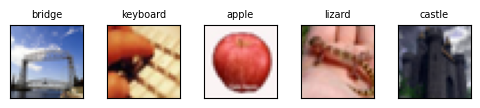

  Converged at epoch: 14. Best validation accuracy: 56.25%
Total backbone weight change during fine-tuning: 15.134538541082293

Fine-tuning on evaluation task 19:


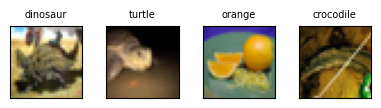

  Converged at epoch:  6. Best validation accuracy: 25.00%
Total backbone weight change during fine-tuning: 8.514573595486581
 +++ AVERAGE META-TEST ACCURACY: 49.40% +++ 


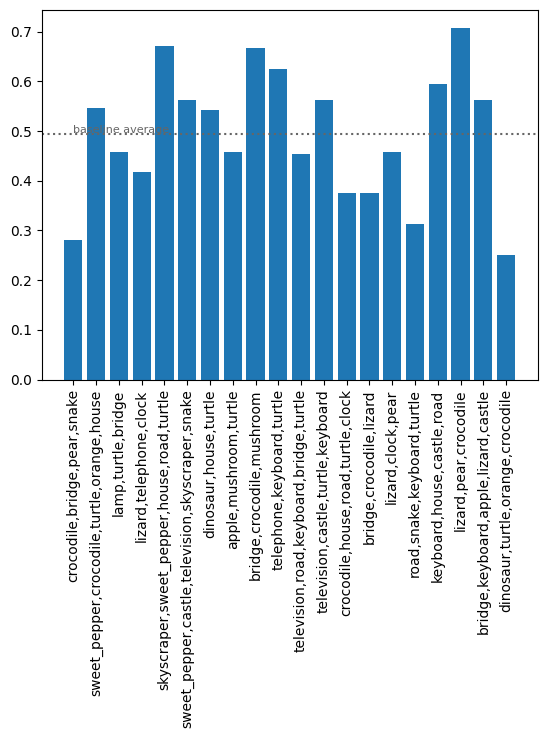

     (after 2500 pre-training steps)


In [13]:


def finetune_on_task(backbone, task_loaders, verbose=True, early_stopping=True):
    """accepts a resnet backbone, and a pair of (support,query) task loaders.
    defines a new classification head to attach to the backbone, and fine-tunes it
    on the supplied task.
    returns:
        the fine-tuned class head,
        final validation (query) accuracy
        training metrics on the chosen task.
    note that the supplied backbone is trained in-place, so its weights will be updated
    outside of the function."""

    support_loader, query_loader = task_loaders
    num_classes = len(support_loader.dataset.classes)

    task_head = ClassifierHead(input_size=1000,
                                         projection_size=64, # smaller due to fewer classes
                                         num_classes=num_classes,
                                         dropout=0,
                                        ).to(device)

    task_model = nn.Sequential(backbone, task_head)

    # Store initial weights
    initial_weights = [param.clone() for param in backbone.parameters()]

    # fine-tune the few-shot task model on our tiny meta-test dataset:
    max_epochs = 100
    lr = 1e-4               # initial learning rate (lower for fine-tuning)
    l2_reg = 1e-3           # L2 loss term
    gamma = 1               # exponential LR decay term
    early_stopping = early_stopping   # detect convergence automatically

    task_acc, task_metrics = train_supervised(task_model,
                                support_loader, query_loader,
                                max_epochs, lr, l2_reg, gamma,
                                early_stopping=early_stopping,
                                plot=False, show_progress=False, verbose=verbose)

    # Compute weight changes
    weight_diffs = [torch.norm(p1 - p0).item() for p0, p1 in zip(initial_weights, backbone.parameters())]
    total_weight_change = sum(weight_diffs)

    if verbose:
        print(f'Total backbone weight change during fine-tuning: {total_weight_change}')

    return task_head, task_acc, task_metrics


def meta_evaluate(backbone,
                  verbose=False,
                  show_taskwise_accuracy=True,
                  model_name='',
                  baseline_avg=None):
    print(f'{model_name} evaluation on meta-test set:'.capitalize())

    meta_test_losses = []
    meta_test_accs = []
    for t, task in enumerate(meta_test_tasks):

        # re-initialise backbone from supplied state:
        task_backbone = initialise_backbone()
        task_backbone.load_state_dict(backbone.state_dict())

        if verbose:
            print(f'\nFine-tuning on evaluation task {t}:')
            inspect_task(task)

        support_loader, query_loader = [torch.utils.data.DataLoader(dset,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True)
                                            for dset in task]

        task_loaders = (support_loader, query_loader)


        task_head, task_acc, task_metrics = finetune_on_task(task_backbone,
                                                             task_loaders,
                                                             verbose=verbose)

        # record meta-test accuracy:
        meta_test_accs.append(task_acc)

        # and meta-test loss, which is the final test loss of the task:
        meta_test_losses.append(task_metrics[1][-1])

    avg_meta_test_loss = np.mean(meta_test_losses)
    avg_meta_test_acc = np.mean(meta_test_accs)
    print(f' +++ AVERAGE META-TEST ACCURACY: {avg_meta_test_acc:.2%} +++ ')


    if show_taskwise_accuracy:
        # display bar plot with accuracy on each evaluation task
        plt.bar(x = range(len(meta_test_task_classes)), height=meta_test_accs)
        plt.xticks(range(len(meta_test_task_classes)), [','.join(cls) for cls in meta_test_task_classes], rotation='vertical')
        plt.axhline(avg_meta_test_acc, c=[0.4]*3, linestyle=':')
        plt.text(0, avg_meta_test_acc+0.002, f'{model_name} average', c=[0.4]*3, size=8)

        if baseline_avg is not None:
            plt.axhline(baseline_avg, c=[0.6]*3, linestyle=':')
            plt.text(0, baseline_avg+0.002, 'baseline average', c=[0.6]*3, size=8)
        plt.show()

    return avg_meta_test_loss, avg_meta_test_acc


# load pre-trained backbone:
baseline_backbone_pt = initialise_backbone()
baseline_backbone_pt.load_state_dict(torch.load('ckpts/pretrained_backbone.pt', weights_only=True))

baseline_meta_test_loss, baseline_meta_test_acc = meta_evaluate(baseline_backbone_pt, model_name='baseline', verbose=True)

baseline_steps_trained = len(baseline_pretrain_metrics[0])
print(f'     (after {baseline_steps_trained} pre-training steps)')

### Task 1: Meta-Training with Reptile

Now your job is to implement the Reptile algorithm for meta-learning - or at least a working approximation of it -  as described at the top of this notebookk

Instead of pre-training on the entire space of meta-training classes by random sampling, randomly create many small few-shot training tasks, and train a meta-model on these.

![maml_vs_reptile.png](https://i.imgur.com/dIvtUAu.png)

Intuitively, Reptile guides the meta-model into a part of the task space that is near many other useful tasks, allowing it to fine-tune quickly and effectively, even generalising into new, unseen tasks.

If you do it correctly, the final performance of your meta-model on the meta-evaluation task should be quite a lot better than the pre-trained baseline.


I've defined a few helper functions for helping you track the progress of your meta-model (the meta-metrics), but the implementation is up to you.

It's a hard task, good luck! If anything isn't clear, ask for help and I'll do my best to explain more of the intuition.

  Converged at epoch:  2. Best validation accuracy: 33.33%
Total backbone weight change during fine-tuning: 5.696002130396664
  Converged at epoch:  4. Best validation accuracy: 41.67%
Total backbone weight change during fine-tuning: 8.49252015852835
  Converged at epoch:  2. Best validation accuracy: 15.00%
Total backbone weight change during fine-tuning: 5.6469124982832
  Converged at epoch:  2. Best validation accuracy: 20.00%
Total backbone weight change during fine-tuning: 5.632877070223913
  Converged at epoch:  2. Best validation accuracy: 25.00%
Total backbone weight change during fine-tuning: 5.664807491120882
  Converged at epoch:  2. Best validation accuracy: 20.00%
Total backbone weight change during fine-tuning: 5.625096541480161
  Converged at epoch:  2. Best validation accuracy: 25.00%
Total backbone weight change during fine-tuning: 5.654425306245685
  Converged at epoch:  2. Best validation accuracy: 25.00%
Total backbone weight change during fine-tuning: 5.62056572816

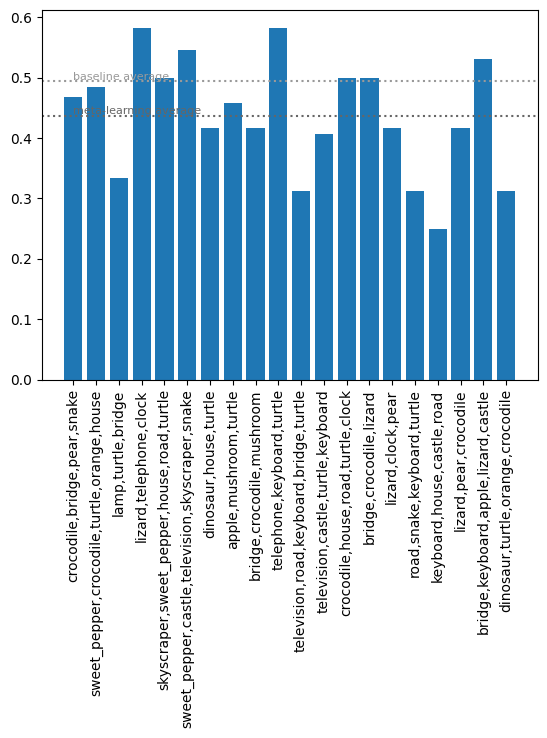

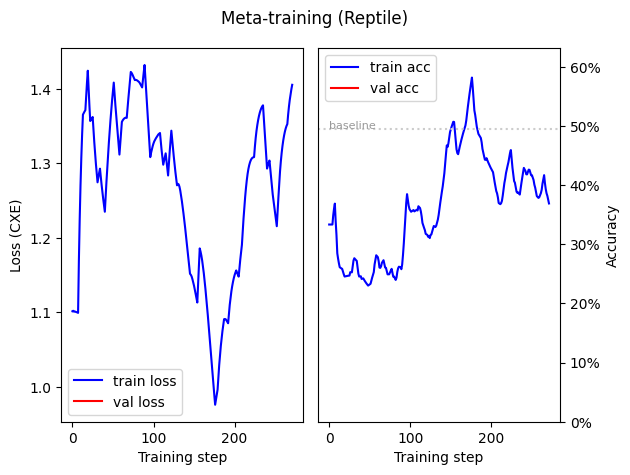

  Converged at epoch:  8. Best validation accuracy: 40.00%
Total backbone weight change during fine-tuning: 11.702829401707277
  Converged at epoch:  3. Best validation accuracy: 50.00%
Total backbone weight change during fine-tuning: 6.303337779361755
  Converged at epoch:  7. Best validation accuracy: 35.00%
Total backbone weight change during fine-tuning: 10.608359880745411
  Converged at epoch: 22. Best validation accuracy: 62.50%
Total backbone weight change during fine-tuning: 23.471031967550516
  Converged at epoch: 16. Best validation accuracy: 56.25%
Total backbone weight change during fine-tuning: 18.58885842934251
  Converged at epoch:  2. Best validation accuracy: 25.00%
Total backbone weight change during fine-tuning: 5.024426080053672
  Converged at epoch:  2. Best validation accuracy: 50.00%
Total backbone weight change during fine-tuning: 5.032345095532946
  Converged at epoch:  6. Best validation accuracy: 35.00%
Total backbone weight change during fine-tuning: 9.33570

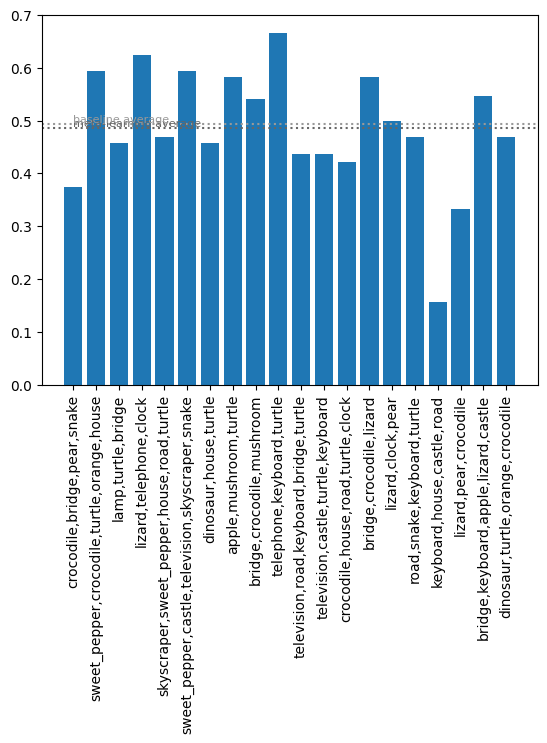

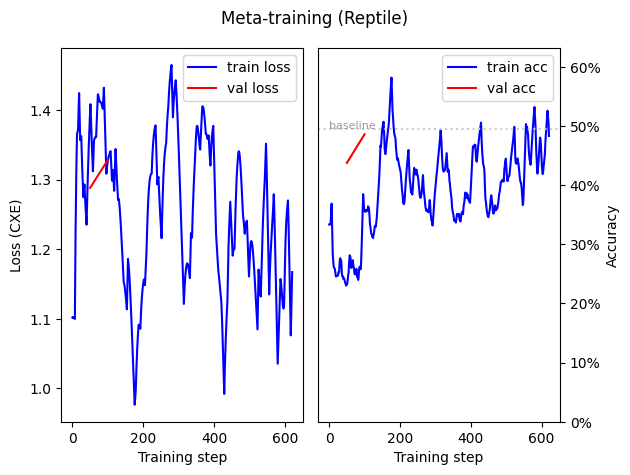

  Converged at epoch:  4. Best validation accuracy: 58.33%
Total backbone weight change during fine-tuning: 6.358797476394102
  Converged at epoch:  8. Best validation accuracy: 35.00%
Total backbone weight change during fine-tuning: 9.814624399412423
  Converged at epoch:  4. Best validation accuracy: 58.33%
Total backbone weight change during fine-tuning: 6.3961505859624594
  Converged at epoch:  2. Best validation accuracy: 33.33%
Total backbone weight change during fine-tuning: 4.404640573891811
  Converged at epoch:  8. Best validation accuracy: 66.67%
Total backbone weight change during fine-tuning: 9.828583017457277
  Converged at epoch:  2. Best validation accuracy: 25.00%
Total backbone weight change during fine-tuning: 4.389266944373958
  Converged at epoch:  7. Best validation accuracy: 66.67%
Total backbone weight change during fine-tuning: 8.874630712904036
  Converged at epoch:  5. Best validation accuracy: 66.67%
Total backbone weight change during fine-tuning: 7.2114370

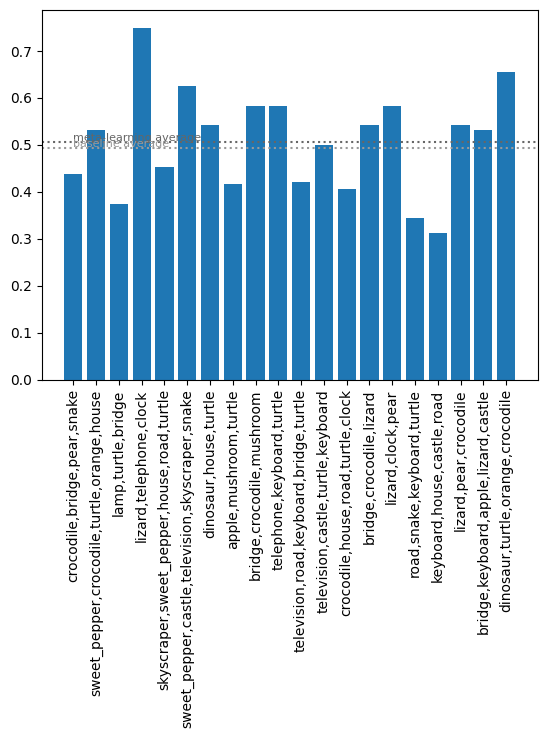

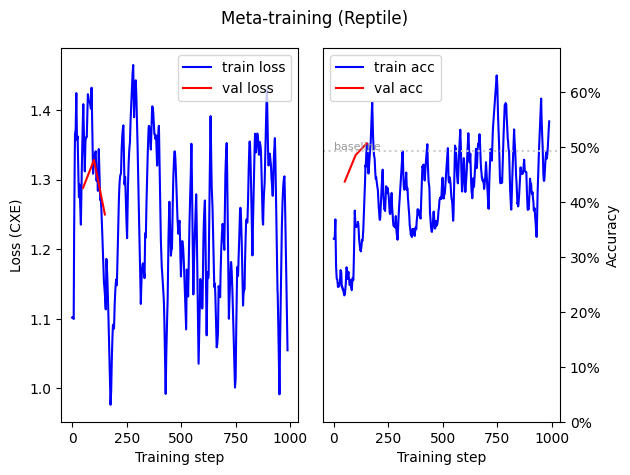

  Converged at epoch:  3. Best validation accuracy: 25.00%
Total backbone weight change during fine-tuning: 4.948823082027957
  Converged at epoch:  8. Best validation accuracy: 45.00%
Total backbone weight change during fine-tuning: 8.805454244371504
  Converged at epoch:  4. Best validation accuracy: 33.33%
Total backbone weight change during fine-tuning: 5.825633208500221
  Converged at epoch:  5. Best validation accuracy: 75.00%
Total backbone weight change during fine-tuning: 6.5097774534951895
  Converged at epoch:  4. Best validation accuracy: 56.25%
Total backbone weight change during fine-tuning: 5.772071393672377
  Converged at epoch:  6. Best validation accuracy: 40.00%
Total backbone weight change during fine-tuning: 7.357571927830577
  Converged at epoch:  3. Best validation accuracy: 41.67%
Total backbone weight change during fine-tuning: 4.954964415170252
  Converged at epoch:  7. Best validation accuracy: 56.25%
Total backbone weight change during fine-tuning: 7.9404567

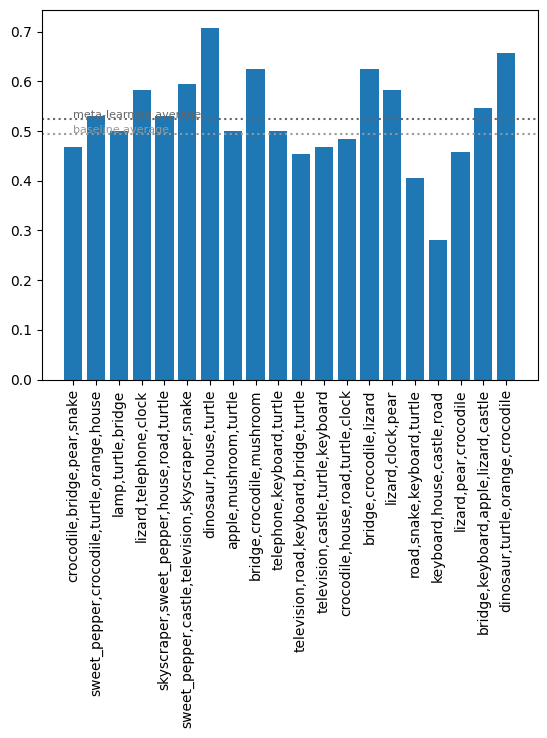

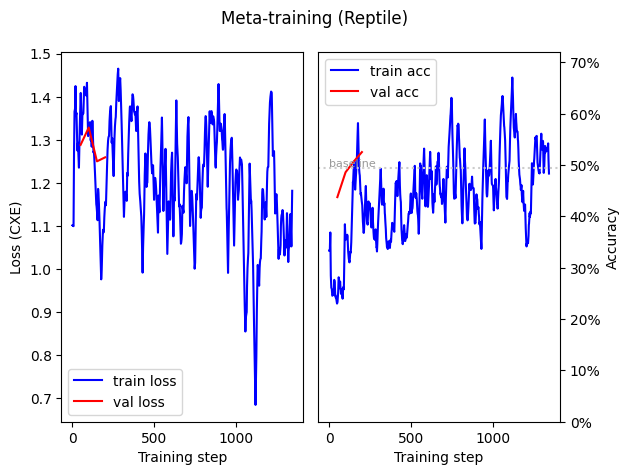

  Converged at epoch: 11. Best validation accuracy: 62.50%
Total backbone weight change during fine-tuning: 10.082475394941866
  Converged at epoch:  7. Best validation accuracy: 50.00%
Total backbone weight change during fine-tuning: 7.9529324534814805
  Converged at epoch:  5. Best validation accuracy: 40.00%
Total backbone weight change during fine-tuning: 6.609466640977189
  Converged at epoch: 13. Best validation accuracy: 65.00%
Total backbone weight change during fine-tuning: 11.23273314232938
  Converged at epoch:  4. Best validation accuracy: 30.00%
Total backbone weight change during fine-tuning: 5.773299735039473
  Converged at epoch:  3. Best validation accuracy: 20.00%
Total backbone weight change during fine-tuning: 4.9136477602878585
  Converged at epoch: 11. Best validation accuracy: 75.00%
Total backbone weight change during fine-tuning: 10.005157477222383
  Converged at epoch:  2. Best validation accuracy: 50.00%
Total backbone weight change during fine-tuning: 4.0373

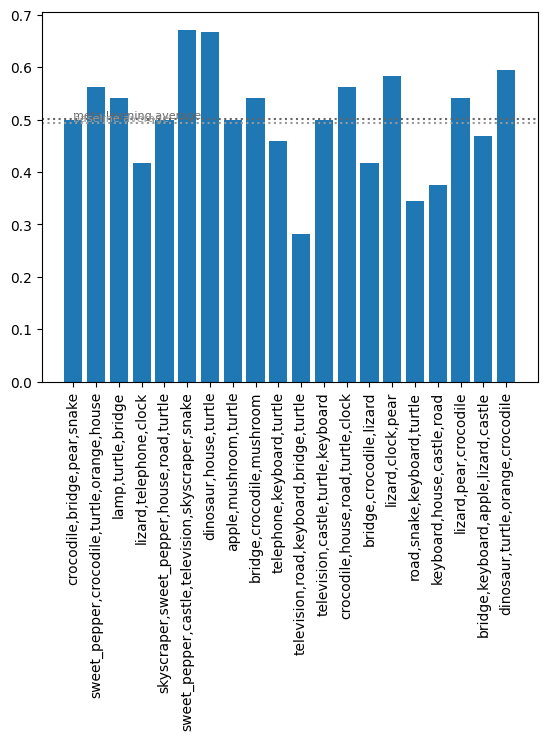

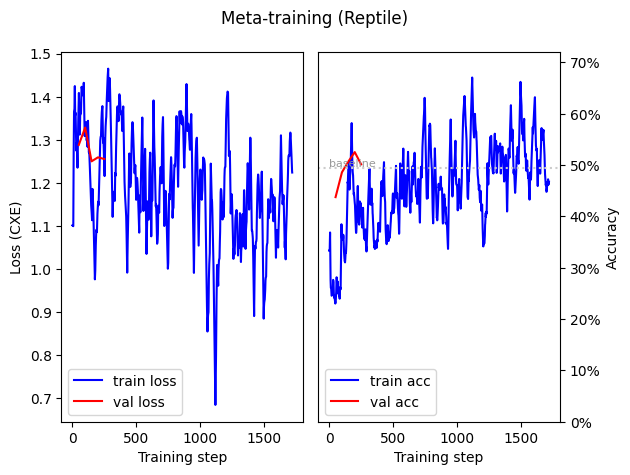

  Converged at epoch:  7. Best validation accuracy: 56.25%
Total backbone weight change during fine-tuning: 7.702810480026528
  Converged at epoch: 10. Best validation accuracy: 75.00%
Total backbone weight change during fine-tuning: 9.490937554743141
  Converged at epoch:  4. Best validation accuracy: 50.00%
Total backbone weight change during fine-tuning: 5.608752395259216
  Converged at epoch:  4. Best validation accuracy: 66.67%
Total backbone weight change during fine-tuning: 5.6026702262461185
  Converged at epoch:  7. Best validation accuracy: 45.00%
Total backbone weight change during fine-tuning: 7.9228951467666775
  Converged at epoch:  3. Best validation accuracy: 37.50%
Total backbone weight change during fine-tuning: 4.906156264478341
  Converged at epoch:  6. Best validation accuracy: 66.67%
Total backbone weight change during fine-tuning: 7.005957501474768
  Converged at epoch:  6. Best validation accuracy: 55.00%
Total backbone weight change during fine-tuning: 7.117928

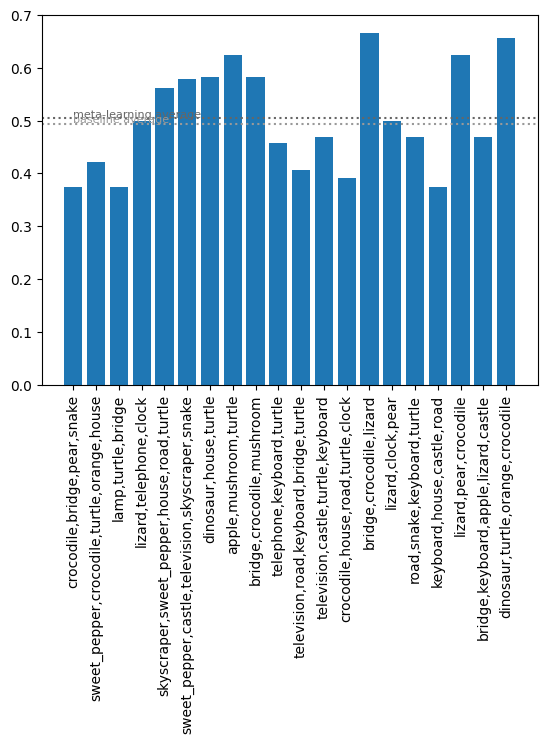

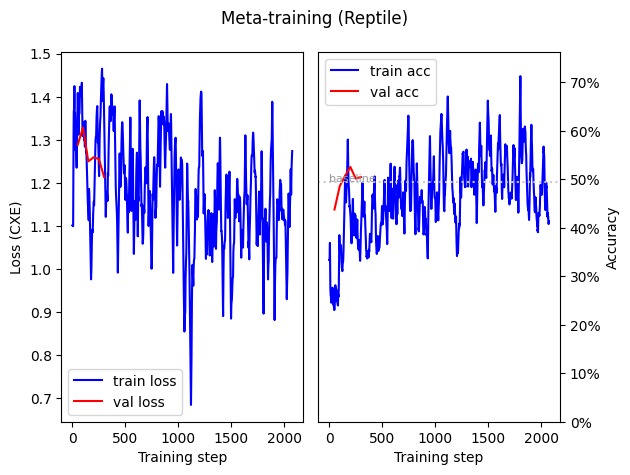

  Converged at epoch:  5. Best validation accuracy: 40.00%
Total backbone weight change during fine-tuning: 6.54030470806174
  Converged at epoch:  4. Best validation accuracy: 40.00%
Total backbone weight change during fine-tuning: 5.653087317827158
  Converged at epoch:  5. Best validation accuracy: 66.67%
Total backbone weight change during fine-tuning: 6.328964967047796
  Converged at epoch:  7. Best validation accuracy: 50.00%
Total backbone weight change during fine-tuning: 7.542705497704446
  Converged at epoch:  6. Best validation accuracy: 75.00%
Total backbone weight change during fine-tuning: 7.020580593729392
  Converged at epoch:  3. Best validation accuracy: 37.50%
Total backbone weight change during fine-tuning: 4.949917477671988
  Converged at epoch:  9. Best validation accuracy: 75.00%
Total backbone weight change during fine-tuning: 8.599531518062577
  Converged at epoch: 10. Best validation accuracy: 66.67%
Total backbone weight change during fine-tuning: 9.142989371

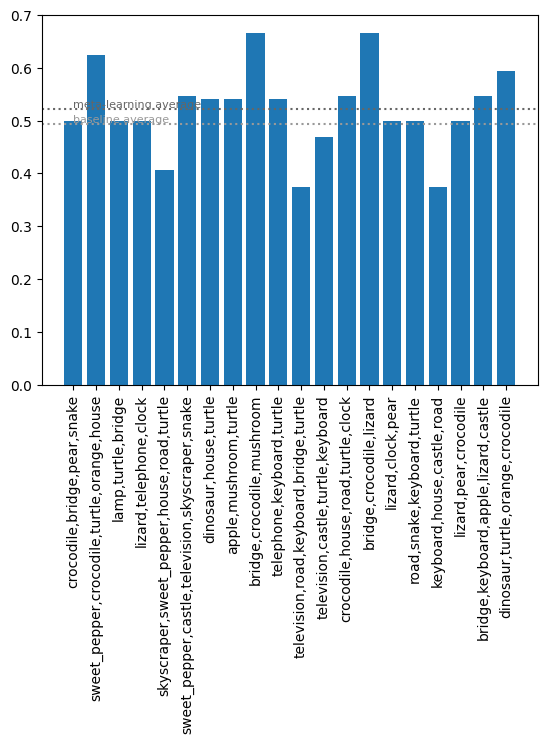

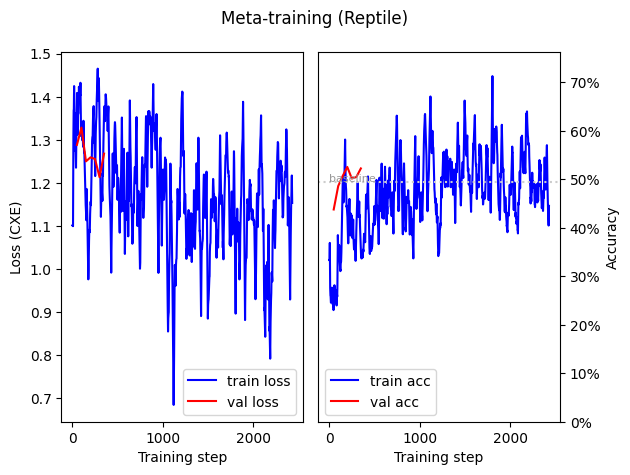

  Converged at epoch:  5. Best validation accuracy: 43.75%
Total backbone weight change during fine-tuning: 6.323275971924886
  Converged at epoch: 11. Best validation accuracy: 60.00%
Total backbone weight change during fine-tuning: 9.91054090578109
  Converged at epoch:  6. Best validation accuracy: 50.00%
Total backbone weight change during fine-tuning: 7.241799158975482
  Converged at epoch:  9. Best validation accuracy: 62.50%
Total backbone weight change during fine-tuning: 8.822419808246195
  Converged at epoch:  7. Best validation accuracy: 83.33%
Total backbone weight change during fine-tuning: 7.525925388326868
  Converged at epoch:  8. Best validation accuracy: 55.00%
Total backbone weight change during fine-tuning: 8.352719167014584
  Converged at epoch: 10. Best validation accuracy: 83.33%
Total backbone weight change during fine-tuning: 9.237375502241775
  Converged at epoch: 11. Best validation accuracy: 65.00%
Total backbone weight change during fine-tuning: 10.25686813

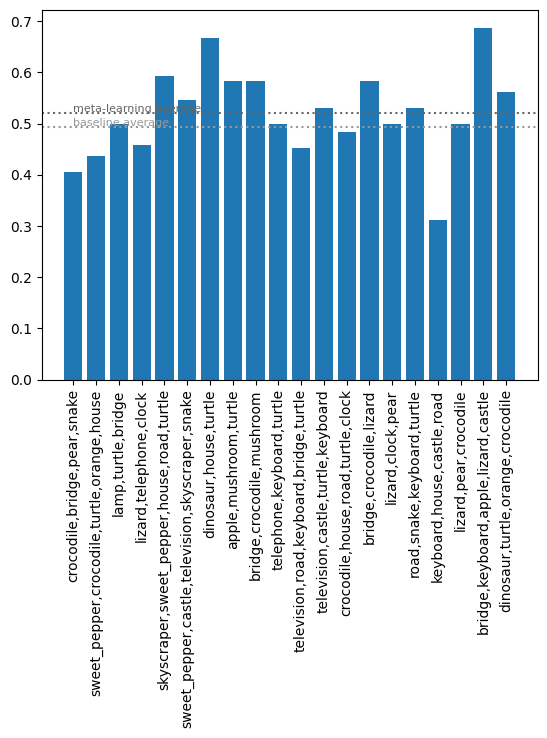

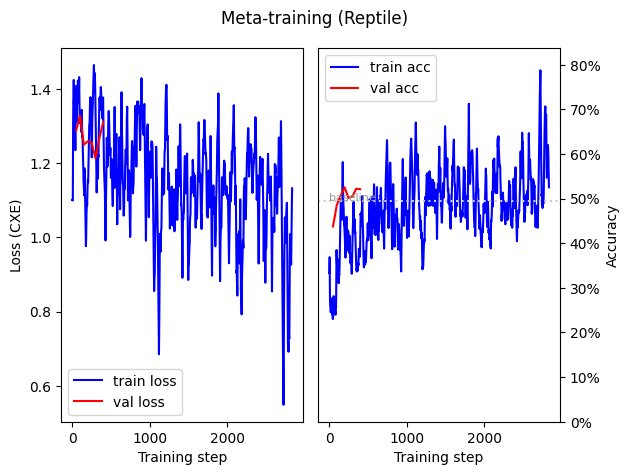

  Converged at epoch: 11. Best validation accuracy: 56.25%
Total backbone weight change during fine-tuning: 9.900583849754184
  Converged at epoch:  6. Best validation accuracy: 56.25%
Total backbone weight change during fine-tuning: 7.1364143246319145
  Converged at epoch:  9. Best validation accuracy: 60.00%
Total backbone weight change during fine-tuning: 8.93933815555647
  Converged at epoch: 13. Best validation accuracy: 65.00%
Total backbone weight change during fine-tuning: 10.977939472300932
  Converged at epoch: 13. Best validation accuracy: 83.33%
Total backbone weight change during fine-tuning: 10.611723073758185
  Converged at epoch:  3. Best validation accuracy: 37.50%
Total backbone weight change during fine-tuning: 4.833706688485108
  Converged at epoch:  5. Best validation accuracy: 50.00%
Total backbone weight change during fine-tuning: 6.355419667903334
  Converged at epoch:  5. Best validation accuracy: 68.75%
Total backbone weight change during fine-tuning: 6.329799

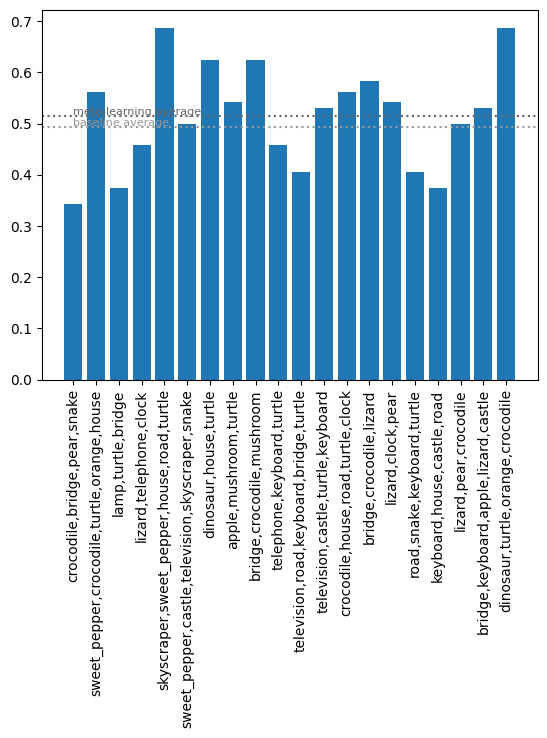

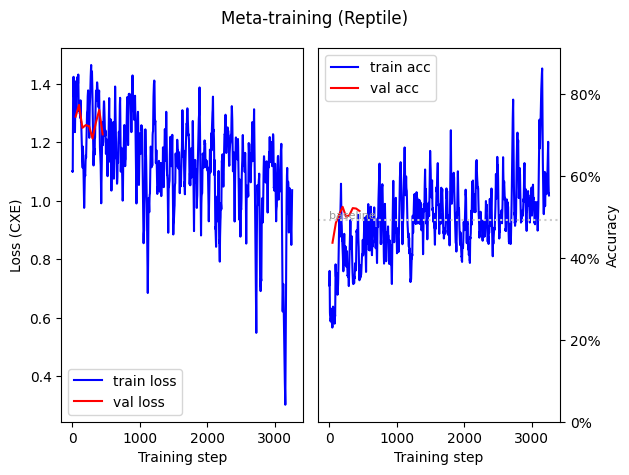

  Converged at epoch:  9. Best validation accuracy: 100.00%
Total backbone weight change during fine-tuning: 8.650538426125422
  Converged at epoch:  4. Best validation accuracy: 55.00%
Total backbone weight change during fine-tuning: 5.691035098396242
  Converged at epoch:  5. Best validation accuracy: 45.00%
Total backbone weight change during fine-tuning: 6.542960810242221
  Converged at epoch:  7. Best validation accuracy: 50.00%
Total backbone weight change during fine-tuning: 7.725768658332527
  Converged at epoch:  7. Best validation accuracy: 50.00%
Total backbone weight change during fine-tuning: 7.840376536827534
  Converged at epoch: 15. Best validation accuracy: 75.00%
Total backbone weight change during fine-tuning: 11.928214517654851
  Converged at epoch:  6. Best validation accuracy: 45.00%
Total backbone weight change during fine-tuning: 7.063089391915128
  Converged at epoch:  9. Best validation accuracy: 62.50%
Total backbone weight change during fine-tuning: 8.669364

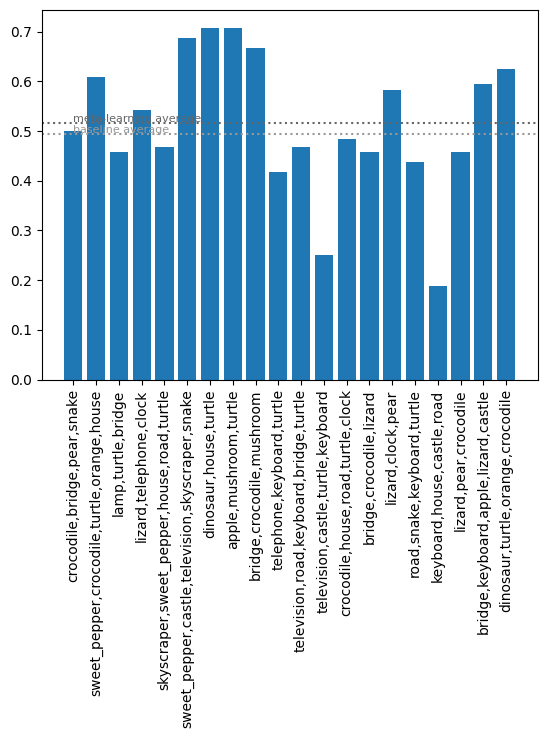

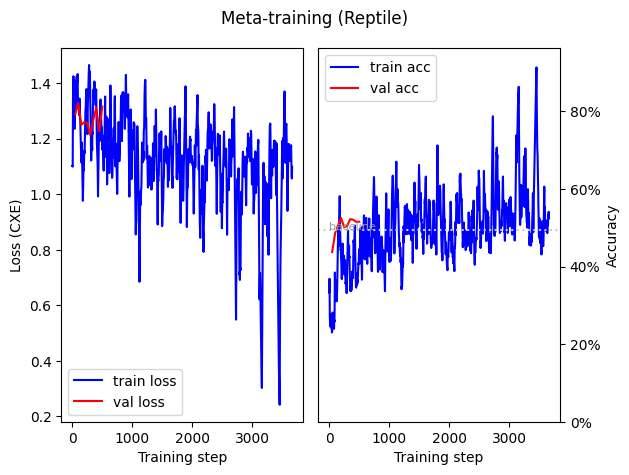

  Converged at epoch:  7. Best validation accuracy: 62.50%
Total backbone weight change during fine-tuning: 7.591152150649577
  Converged at epoch:  6. Best validation accuracy: 56.25%
Total backbone weight change during fine-tuning: 7.011040327372029
  Converged at epoch:  3. Best validation accuracy: 40.00%
Total backbone weight change during fine-tuning: 4.871814542682841
  Converged at epoch:  3. Best validation accuracy: 37.50%
Total backbone weight change during fine-tuning: 4.801750301383436
  Converged at epoch:  4. Best validation accuracy: 50.00%
Total backbone weight change during fine-tuning: 5.64416275289841
  Converged at epoch:  5. Best validation accuracy: 58.33%
Total backbone weight change during fine-tuning: 6.313088336726651
  Converged at epoch:  4. Best validation accuracy: 50.00%
Total backbone weight change during fine-tuning: 5.498716755537316
  Converged at epoch:  5. Best validation accuracy: 50.00%
Total backbone weight change during fine-tuning: 6.430717410

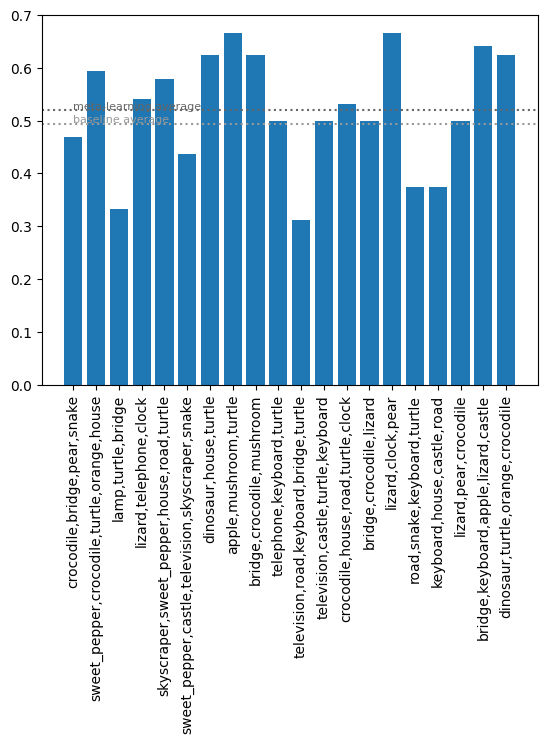

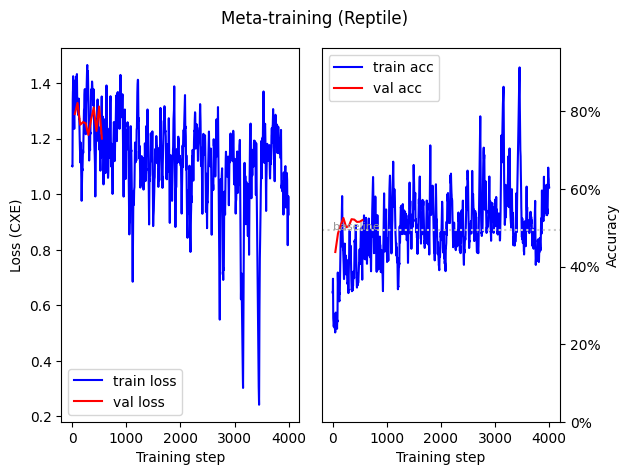

  Converged at epoch:  2. Best validation accuracy: 43.75%
Total backbone weight change during fine-tuning: 3.984613354317844
  Converged at epoch: 11. Best validation accuracy: 70.00%
Total backbone weight change during fine-tuning: 10.05663012387231
  Converged at epoch:  9. Best validation accuracy: 45.00%
Total backbone weight change during fine-tuning: 8.963506426662207
  Converged at epoch:  7. Best validation accuracy: 40.00%
Total backbone weight change during fine-tuning: 7.679667765973136
  Converged at epoch:  4. Best validation accuracy: 40.00%
Total backbone weight change during fine-tuning: 5.684060356812552
  Converged at epoch: 16. Best validation accuracy: 66.67%
Total backbone weight change during fine-tuning: 11.54364362009801
  Converged at epoch:  6. Best validation accuracy: 75.00%
Total backbone weight change during fine-tuning: 7.150913731195033
  Converged at epoch:  8. Best validation accuracy: 83.33%
Total backbone weight change during fine-tuning: 8.10499410

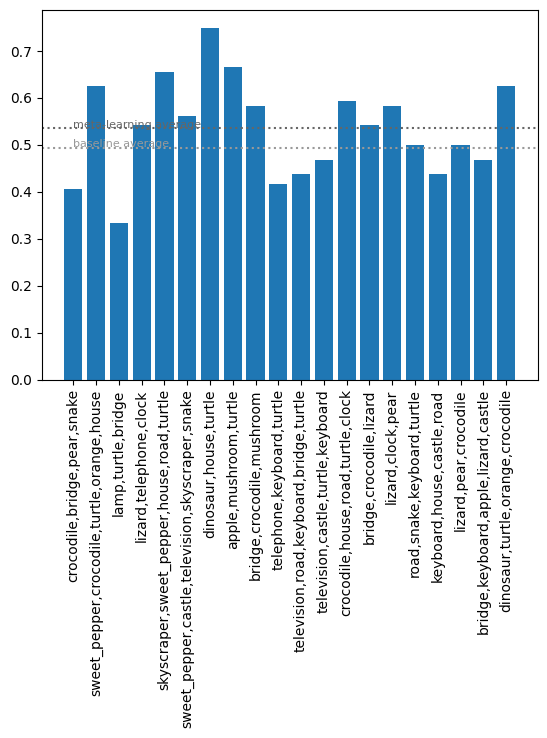

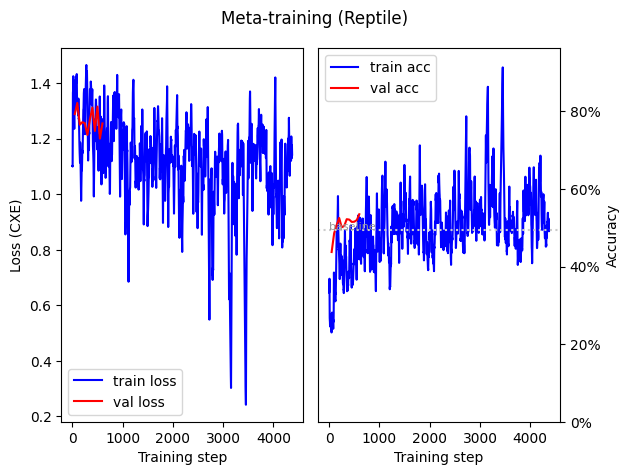

  Converged at epoch:  5. Best validation accuracy: 75.00%
Total backbone weight change during fine-tuning: 6.333631300600246
  Converged at epoch: 12. Best validation accuracy: 56.25%
Total backbone weight change during fine-tuning: 10.068259576102719
  Converged at epoch:  2. Best validation accuracy: 43.75%
Total backbone weight change during fine-tuning: 3.9559197317576036
  Converged at epoch:  4. Best validation accuracy: 30.00%
Total backbone weight change during fine-tuning: 5.609504107036628
  Converged at epoch:  4. Best validation accuracy: 66.67%
Total backbone weight change during fine-tuning: 5.604860557010397
  Converged at epoch:  7. Best validation accuracy: 60.00%
Total backbone weight change during fine-tuning: 7.773108403198421
  Converged at epoch:  9. Best validation accuracy: 87.50%
Total backbone weight change during fine-tuning: 8.708295300835744
  Converged at epoch: 14. Best validation accuracy: 75.00%
Total backbone weight change during fine-tuning: 11.04649

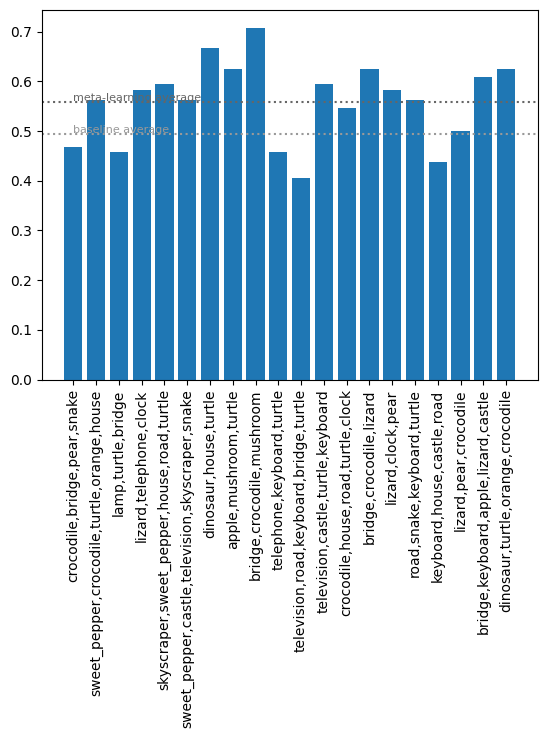

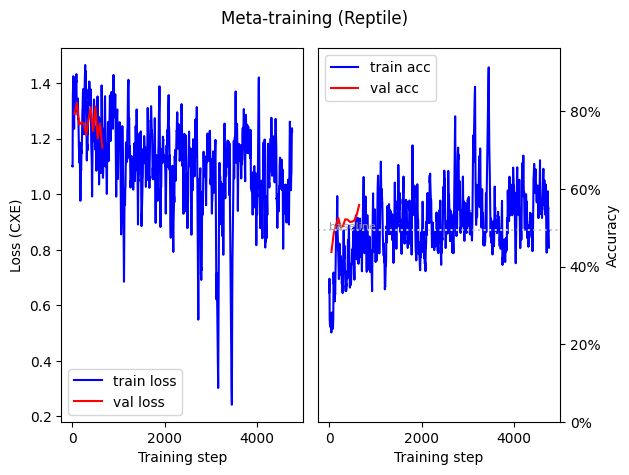

  Converged at epoch:  9. Best validation accuracy: 62.50%
Total backbone weight change during fine-tuning: 8.644891666481271
  Converged at epoch:  2. Best validation accuracy: 40.00%
Total backbone weight change during fine-tuning: 3.9808766967616975
  Converged at epoch:  3. Best validation accuracy: 50.00%
Total backbone weight change during fine-tuning: 4.816770546254702
  Converged at epoch:  4. Best validation accuracy: 33.33%
Total backbone weight change during fine-tuning: 5.479349807486869
  Converged at epoch:  4. Best validation accuracy: 62.50%
Total backbone weight change during fine-tuning: 5.575648490339518
  Converged at epoch:  2. Best validation accuracy: 41.67%
Total backbone weight change during fine-tuning: 3.9144932944327593
  Converged at epoch:  8. Best validation accuracy: 66.67%
Total backbone weight change during fine-tuning: 8.04928222252056
  Converged at epoch:  3. Best validation accuracy: 31.25%
Total backbone weight change during fine-tuning: 4.7740046

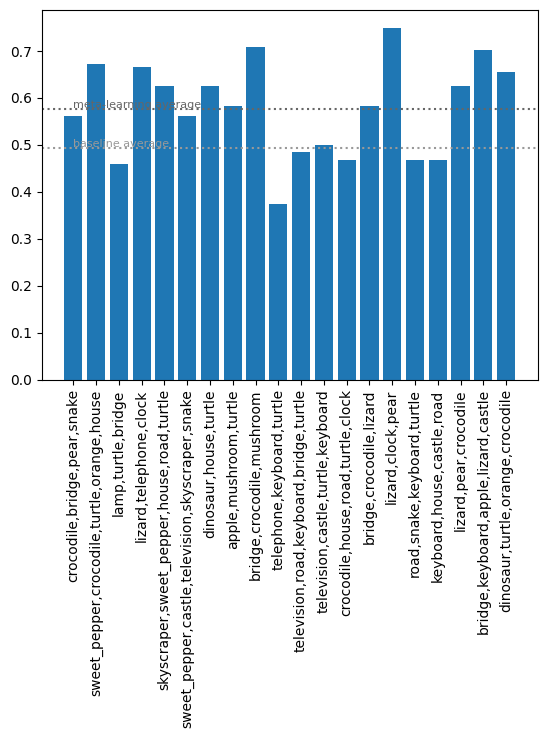

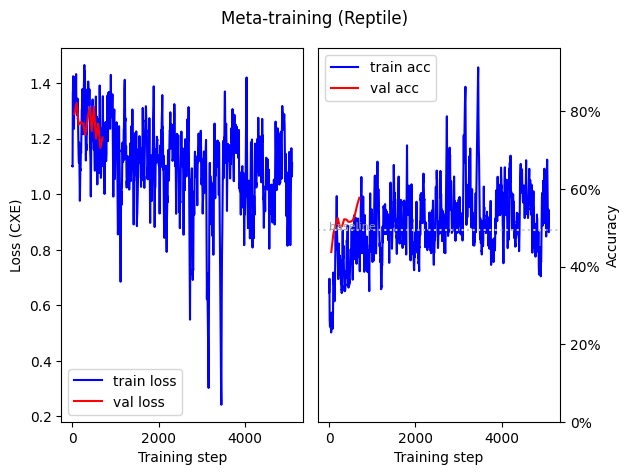

  Converged at epoch:  8. Best validation accuracy: 55.00%
Total backbone weight change during fine-tuning: 8.034565064124763
  Converged at epoch:  6. Best validation accuracy: 50.00%
Total backbone weight change during fine-tuning: 7.099901822861284
  Converged at epoch: 10. Best validation accuracy: 60.00%
Total backbone weight change during fine-tuning: 9.235249560559168
  Converged at epoch:  7. Best validation accuracy: 83.33%
Total backbone weight change during fine-tuning: 7.391629514051601
  Converged at epoch: 17. Best validation accuracy: 81.25%
Total backbone weight change during fine-tuning: 12.125099641736597
  Converged at epoch:  3. Best validation accuracy: 33.33%
Total backbone weight change during fine-tuning: 4.802314588450827
  Converged at epoch: 14. Best validation accuracy: 81.25%
Total backbone weight change during fine-tuning: 10.992566072847694
  Converged at epoch: 13. Best validation accuracy: 75.00%
Total backbone weight change during fine-tuning: 10.38419

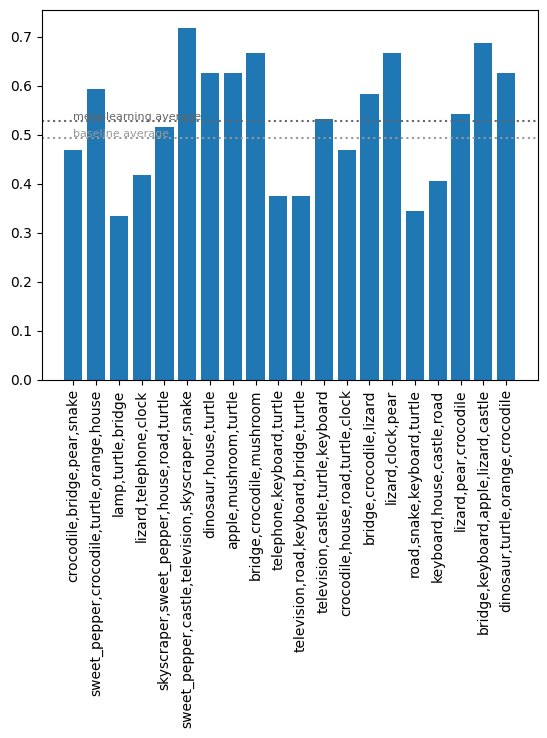

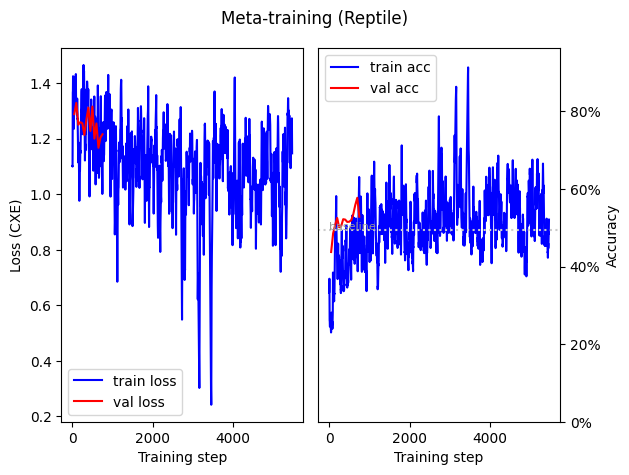

  Converged at epoch:  2. Best validation accuracy: 50.00%
Total backbone weight change during fine-tuning: 3.941594726871699
  Converged at epoch:  5. Best validation accuracy: 30.00%
Total backbone weight change during fine-tuning: 6.2759154862724245
  Converged at epoch:  3. Best validation accuracy: 35.00%
Total backbone weight change during fine-tuning: 4.776743523078039
  Converged at epoch:  3. Best validation accuracy: 25.00%
Total backbone weight change during fine-tuning: 4.788504716358148
  Converged at epoch:  6. Best validation accuracy: 62.50%
Total backbone weight change during fine-tuning: 6.905998835572973
  Converged at epoch:  4. Best validation accuracy: 68.75%
Total backbone weight change during fine-tuning: 5.574016877333634
  Converged at epoch:  8. Best validation accuracy: 75.00%
Total backbone weight change during fine-tuning: 7.927171408198774
  Converged at epoch: 13. Best validation accuracy: 75.00%
Total backbone weight change during fine-tuning: 10.385868

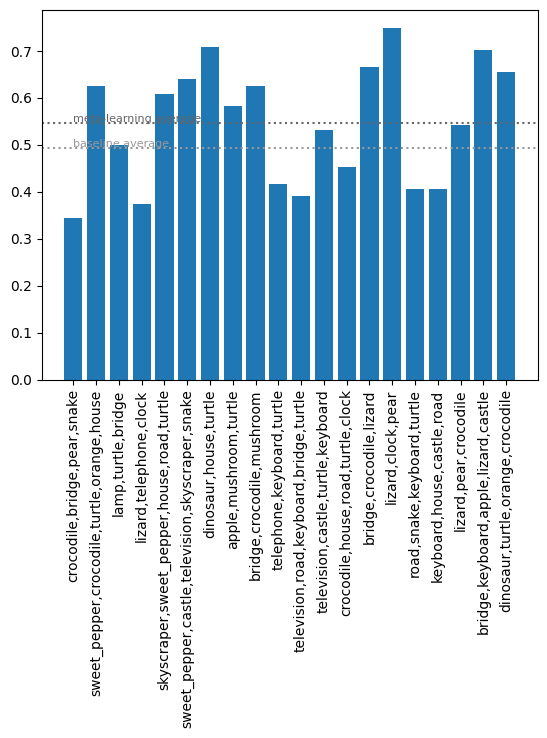

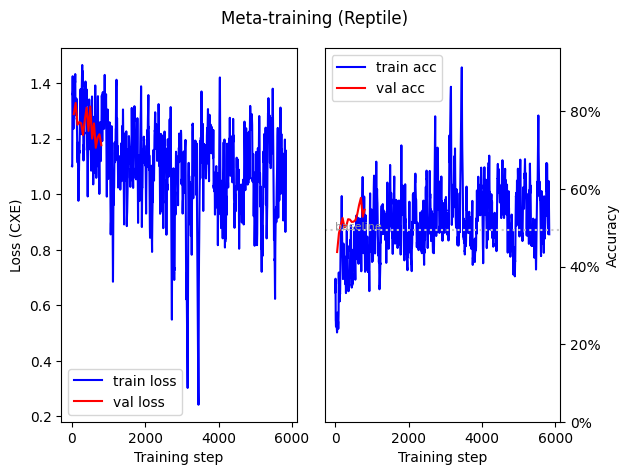

  Converged at epoch:  6. Best validation accuracy: 83.33%
Total backbone weight change during fine-tuning: 6.919379011029378
  Converged at epoch:  8. Best validation accuracy: 43.75%
Total backbone weight change during fine-tuning: 7.941790948156267
  Converged at epoch:  7. Best validation accuracy: 62.50%
Total backbone weight change during fine-tuning: 7.43952992092818
  Converged at epoch:  9. Best validation accuracy: 81.25%
Total backbone weight change during fine-tuning: 8.562085182173178
  Converged at epoch: 24. Best validation accuracy: 100.00%
Total backbone weight change during fine-tuning: 13.84619971178472
  Converged at epoch:  6. Best validation accuracy: 62.50%
Total backbone weight change during fine-tuning: 6.85657614748925
  Converged at epoch:  8. Best validation accuracy: 40.00%
Total backbone weight change during fine-tuning: 8.13652326958254
  Converged at epoch: 11. Best validation accuracy: 56.25%
Total backbone weight change during fine-tuning: 9.6213556714

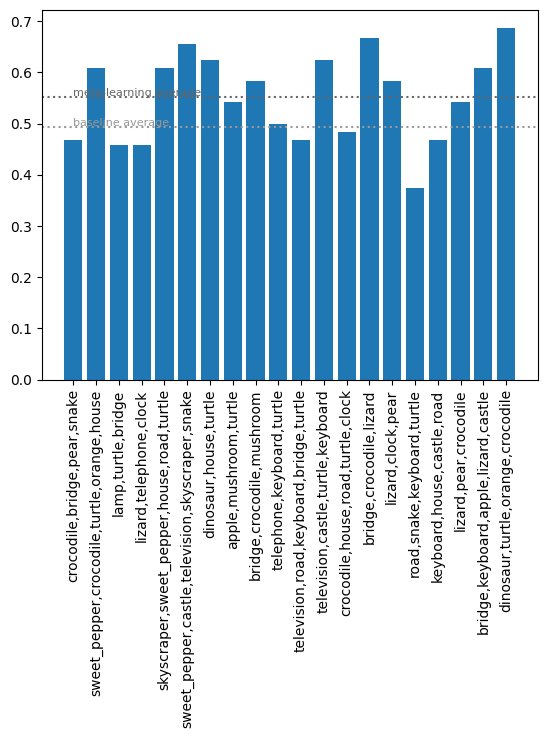

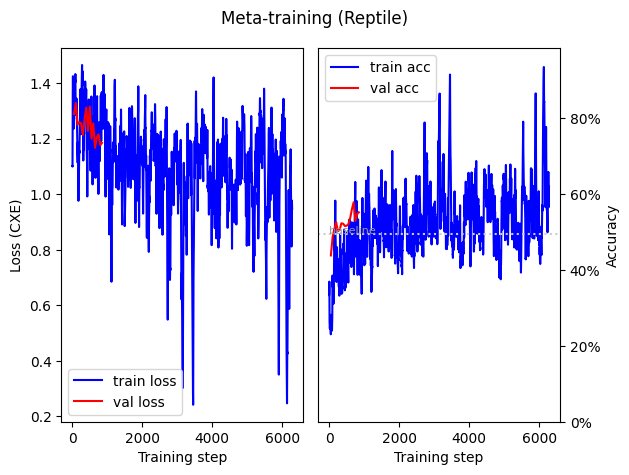

  Converged at epoch:  7. Best validation accuracy: 43.75%
Total backbone weight change during fine-tuning: 7.60495559242554
  Converged at epoch: 10. Best validation accuracy: 81.25%
Total backbone weight change during fine-tuning: 8.90731189143844
  Converged at epoch:  6. Best validation accuracy: 58.33%
Total backbone weight change during fine-tuning: 6.884681450435892
  Converged at epoch:  4. Best validation accuracy: 75.00%
Total backbone weight change during fine-tuning: 5.49635324429255
  Converged at epoch:  2. Best validation accuracy: 37.50%
Total backbone weight change during fine-tuning: 3.952327477163635
  Converged at epoch:  8. Best validation accuracy: 75.00%
Total backbone weight change during fine-tuning: 7.877249491168186
  Converged at epoch:  3. Best validation accuracy: 41.67%
Total backbone weight change during fine-tuning: 4.721951520885341
  Converged at epoch:  5. Best validation accuracy: 25.00%
Total backbone weight change during fine-tuning: 6.27121569495

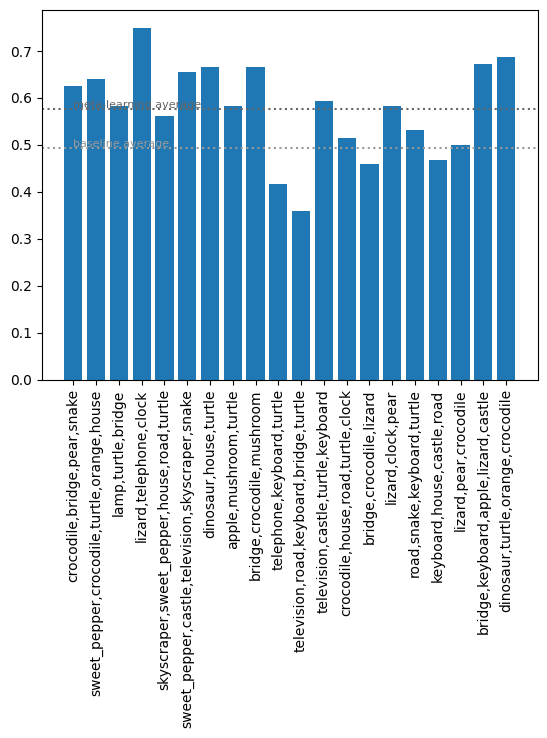

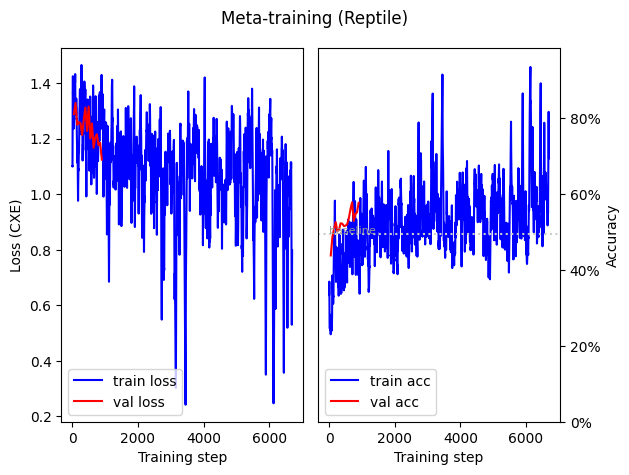

  Converged at epoch:  7. Best validation accuracy: 50.00%
Total backbone weight change during fine-tuning: 7.536548429634422
  Converged at epoch: 13. Best validation accuracy: 75.00%
Total backbone weight change during fine-tuning: 10.725110864499584
  Converged at epoch: 11. Best validation accuracy: 75.00%
Total backbone weight change during fine-tuning: 9.426110671600327
  Converged at epoch: 11. Best validation accuracy: 91.67%
Total backbone weight change during fine-tuning: 9.185484464280307
  Converged at epoch:  7. Best validation accuracy: 83.33%
Total backbone weight change during fine-tuning: 7.391397367231548
  Converged at epoch:  7. Best validation accuracy: 58.33%
Total backbone weight change during fine-tuning: 7.399136595660821
  Converged at epoch:  6. Best validation accuracy: 62.50%
Total backbone weight change during fine-tuning: 7.040000703185797
  Converged at epoch:  8. Best validation accuracy: 75.00%
Total backbone weight change during fine-tuning: 7.7985633

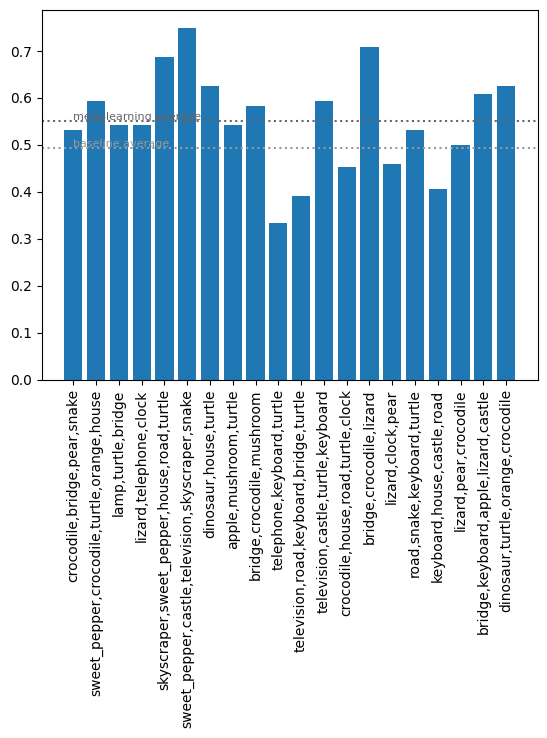

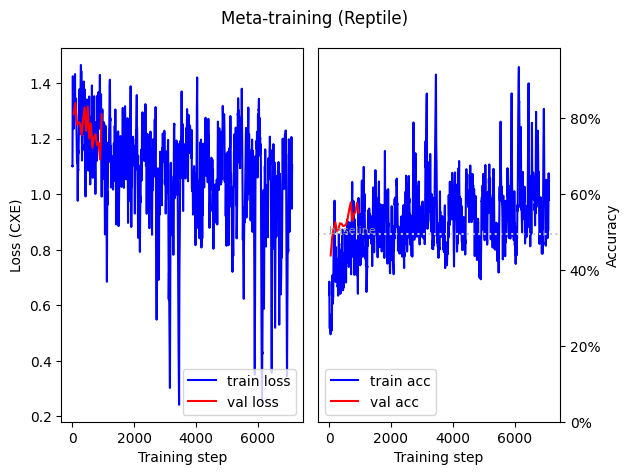

  Converged at epoch:  3. Best validation accuracy: 50.00%
Total backbone weight change during fine-tuning: 4.754437223193236
  Converged at epoch:  6. Best validation accuracy: 60.00%
Total backbone weight change during fine-tuning: 7.078678595134988
  Converged at epoch:  6. Best validation accuracy: 68.75%
Total backbone weight change during fine-tuning: 6.836713385302573
  Converged at epoch:  3. Best validation accuracy: 31.25%
Total backbone weight change during fine-tuning: 4.754993287380785
  Converged at epoch:  6. Best validation accuracy: 55.00%
Total backbone weight change during fine-tuning: 6.992497365688905
  Converged at epoch:  7. Best validation accuracy: 45.00%
Total backbone weight change during fine-tuning: 7.6521049197763205
  Converged at epoch: 11. Best validation accuracy: 75.00%
Total backbone weight change during fine-tuning: 9.397930834209546
  Converged at epoch:  7. Best validation accuracy: 75.00%
Total backbone weight change during fine-tuning: 7.2422397

In [26]:
max_episodes = 1000
meta_evaluate_interval = 50

#define epsilon meta-hyper-parameter that controls how much the weights of the finetuned model in the new task affect the metamodel.
epsilon = 0.5


def update_meta_model(meta_backbone, task_backbone, epsilon=0.5):
    '''Updates the meta_backbone by using the reptile algorithm:
            meta_backbone_weights_new = meta_backbone_weights + epsilon(task_backbone_weights - meta_backbone_weights)
    return the updated meta_backbone
    '''
    with torch.no_grad():
        meta_state_dict = meta_backbone.state_dict()
        task_state_dict = task_backbone.state_dict()
        
        for key in meta_state_dict:
            meta_state_dict[key] = meta_state_dict[key] + epsilon * (task_state_dict[key] - meta_state_dict[key])
        
        meta_backbone.load_state_dict(meta_state_dict)

    return meta_backbone

# initialise your metamodel:
meta_backbone = initialise_backbone() #this is the metamodel i want to update the weights of



# track metrics for plotting training curves:
meta_train_losses, meta_train_accs = [], []
meta_val_losses, meta_val_accs = [], []
episode_steps = [] # used for plotting val loss at the correct x-position
meta_metrics = [meta_train_losses, meta_val_losses,
                meta_train_accs, meta_val_accs,
                episode_steps]



for m in range(max_episodes):

    #Every episode generate a new task
    support_data, query_data = create_task(num_support=4, # number of examples per class for support set
                    num_query=4,   # number of examples per class for query set
                    N_choices = [3,4,5], # choice of N-way classification
                    meta_test=True, # generate from meta-test classes instead of meta-train classes
                    within_superclass=False, # generate from within a superclass (for harder tasks)
                )

    support_loader, query_loader = [torch.utils.data.DataLoader(dset,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True)
                                    for dset in (support_data, query_data)]

    task_loaders = (support_loader, query_loader)

    task_backbone = initialise_backbone()
    task_backbone.load_state_dict(meta_backbone.state_dict())

    # your meta-training code here
    task_head, task_acc, task_metrics= finetune_on_task(task_backbone, task_loaders, verbose=True, early_stopping=True)

    #update the meta-model based on the reptile algorithm
    meta_backbone = update_meta_model(meta_backbone, task_backbone, epsilon)

    #log train metrics
    meta_train_losses.extend(task_metrics[1])
    meta_train_accs.extend(task_metrics[3])




    # evaluate every so often:
    if (m % meta_evaluate_interval == 0) and (m > 0):
        meta_test_task_losses, meta_test_task_accs = meta_evaluate(meta_backbone,
                                                           baseline_avg=baseline_meta_test_acc,
                                                           model_name='meta-learning')

        meta_val_losses.append(np.mean(meta_test_task_losses))
        meta_val_accs.append(np.mean(meta_test_task_accs))
        episode_steps.append(m)

        # show meta-training plot as meta-training progresses
        training_plot(meta_metrics, title=f'Meta-training (Reptile)', baselines={'baseline': baseline_meta_test_acc})


### Task 2: Meta-Evaluation and Assessment

Run the code below to evaluate the effectiveness of your meta model.

Then report your results as usual:

* Show **a few plots** demonstrating your meta-training process and how your meta-model learns to generalise to new tasks, comparing its final meta-validation accuracy to that of the baseline pre-trained model.
    
* Also write **a few sentences** summarising any particular issues you ran into, how you solved them, and any other insights you gained about designing/implementing the meta-learning process.

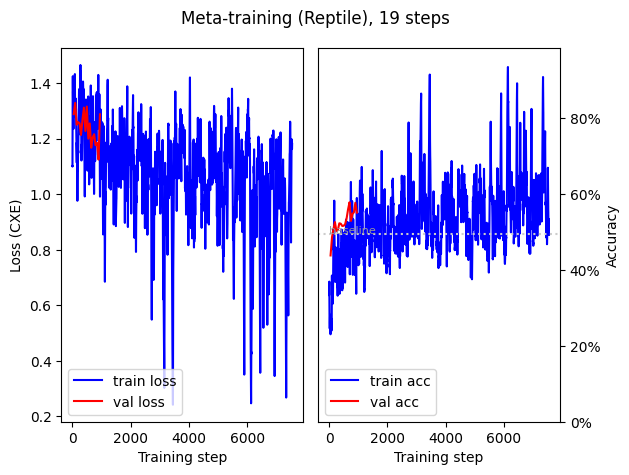

Meta-learning evaluation on meta-test set:
 +++ AVERAGE META-TEST ACCURACY: 59.04% +++ 


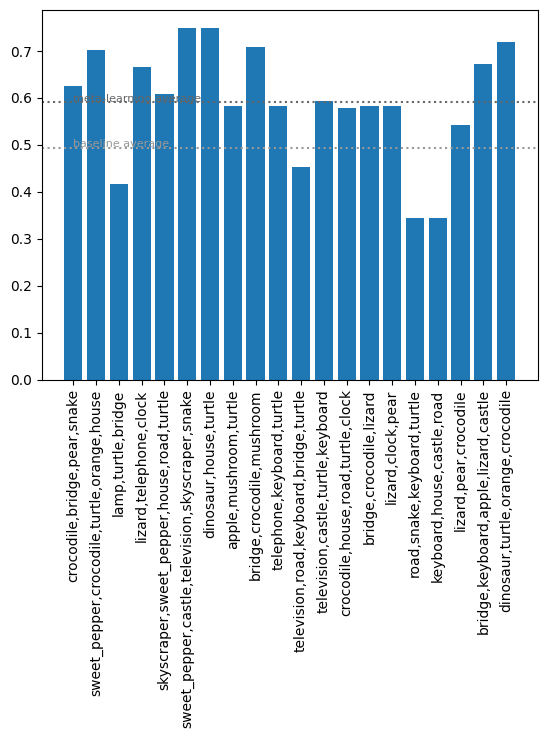

(1.1759305059909821, 0.590364596247673)

In [27]:
# final meta-training metrics:
total_steps_trained = len(meta_metrics[4])
training_plot(meta_metrics,
              title=f'Meta-training (Reptile), {total_steps_trained} steps',
              baselines={'baseline': baseline_meta_test_acc})

# final meta-evaluation:
meta_evaluate(meta_backbone,
               baseline_avg=baseline_meta_test_acc,
               model_name='meta-learning')

Good luck! If you have any problems, especially regarding understanding the meta-learning abstraction or the meta-training framework, don't hesitate to ask for help.